# **Location of the 20C Surface Isotherm**
Created by L. Gruenburg
Last edited 12/11/2024

In [1]:
#import necessary packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import xarray as xr
import cartopy
import pandas as pn
from datetime import datetime
import gsw
#from holteandtalley import HolteAndTalley
import os
from xmovie import Movie
from shapely.geometry import Polygon, Point, MultiPolygon
import shapefile
import geopandas as gpd
import cartopy
import cartopy.crs as ccrs
import geopandas as gpd
import pyogrio

## Open all SST data
SST data were obtained from OISST satellite product using Rscript GetOISST.Rmd

In [3]:
sst1 = xr.open_dataset('/Users/ian/Desktop/*NYB Indicators/CalculateIndicators/WaterTemperature/Data/OISST1.nc')

In [5]:
sst2 = xr.open_dataset('/Users/ian/Desktop/*NYB Indicators/CalculateIndicators/WaterTemperature/Data/OISST2.nc')
sst3 = xr.open_dataset('/Users/ian/Desktop/*NYB Indicators/CalculateIndicators/WaterTemperature/Data/OISST3.nc')
sst4 = xr.open_dataset('/Users/ian/Desktop/*NYB Indicators/CalculateIndicators/WaterTemperature/Data/OISST4.nc')
sst5 = xr.open_dataset('/Users/ian/Desktop/*NYB Indicators/CalculateIndicators/WaterTemperature/Data/OISST5.nc')
sst6 = xr.open_dataset('/Users/ian/Desktop/*NYB Indicators/CalculateIndicators/WaterTemperature/Data/OISST6.nc')
sst7 = xr.open_dataset('/Users/ian/Desktop/*NYB Indicators/CalculateIndicators/WaterTemperature/Data/OISST7.nc')

In [9]:
# sst8 = xr.open_dataset('/Users/nyelab/Desktop/NYB Indicators/CalculateIndicators/WaterTemperature/Data/CV/OISST_v2.1/OISST_daily_v2.1_2022jul_2023nov.nc')

In [7]:
# Put all netcdfs together
# sst = xr.merge([sst1,sst2,sst3,sst4,sst5,sst6,sst7,sst8])
sst = xr.merge([sst1,sst2,sst3,sst4,sst5,sst6,sst7])

## Load required shapefile

In [11]:
# Load NYB shapefile
NYB = gpd.read_file('/Users/ian/Documents/GitHub/NYB_Indicators_Calculations-main/Datasets/Shapefiles/PlanningArea_NYocean_NYSDOS.shp')

In [13]:
# Alter the projection to WGS84 see https://epsg.io/4326
NYB = NYB.to_crs(epsg=4326)

In [15]:
# Extract the polygon
nyb_shape = NYB.geometry[0]

## Begin data analysis

In [17]:
# Prep years to loop through and group by season each time
unique_years = np.unique(pn.to_datetime(sst.time.values).year)
years = pn.to_datetime(sst.time.values).year

In [19]:
len(unique_years)*4 # number of seasons total (4 per year)

172

In [21]:
# Test the groupby seasons function
seas = sst.groupby('time.season').mean('time')

In [23]:
seas

<xarray.Dataset>
Dimensions:    (zlev: 1, latitude: 57, longitude: 61, season: 4)
Coordinates:
  * zlev       (zlev) float32 0.0
  * latitude   (latitude) float32 32.12 32.38 32.62 32.88 ... 45.62 45.88 46.12
  * longitude  (longitude) float32 -79.88 -79.62 -79.38 ... -65.38 -65.12 -64.88
  * season     (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    sst        (season, zlev, latitude, longitude) float32 18.85 20.01 ... nan
Attributes: (12/46)
    cdm_data_type:              Grid
    comment:                    Data was converted from NetCDF-3 to NetCDF-4 ...
    Conventions:                CF-1.6, ACDD-1.3, COARDS
    creator_email:              oisst-help@noaa.gov
    creator_name:               NOAA NCEI
    creator_type:               group
    ...                         ...
    summary:                    This is the final version of the related data...
    testOutOfDate:              now-17days
    time_coverage_end:          1985-12-31T12:00:00Z
    time_coverage_start:        1982-01-01T12:00:00Z
    title:                      SST, Daily Optimum Interpolation (OI), AVHRR ...
    Westernmost_Easting:        -79.875

In [25]:
unique_years

array([1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024],
      dtype=int32)

In [27]:
# Get seasonal means for each year.  Our last complete month is October 2023,
# sofor the last year and the Autumn is only 2 months

empty = np.empty([172,len(sst.latitude),len(sst.longitude)])
empty[:,:,:] = np.nan
k=0
for i in unique_years[:-1]:
    index = np.where(years == i)
    sst_subset = sst.sst[index[0],0,:,:]
    sst_subset_seas = sst_subset.groupby('time.season').mean('time')
    empty[k:k+4,:,:] = sst_subset_seas
    k=k+4
index = np.where(years == 2024)
sst_subset = sst.sst[index[0],0,:,:]
sst_subset_seas = sst_subset.groupby('time.season').mean('time')
empty[k:k+4,:,:] = sst_subset_seas
sst_seas = empty

In [29]:
# Look at the data - seasonal climatology
sst_subset_seas

<xarray.DataArray 'sst' (season: 4, latitude: 57, longitude: 61)>
array([[[16.920332 , 18.86133  , 20.671165 , ..., 19.917833 ,
         19.83967  , 19.77817  ],
        [14.746836 , 16.671669 , 18.810331 , ..., 19.716166 ,
         19.642832 , 19.600498 ],
        [12.8525   , 14.123668 , 16.219334 , ..., 19.583336 ,
         19.541166 , 19.522335 ],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,  2.5825   ],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[28.349562 , 28.458698 , 28.725008 , ..., 26.794676 ,
         26.784788 , 26.770754 ],
        [28.34109  , 28.267063 , 28.37717  , ..., 26.766844 ,
         26.76772  , 26.754026 ],
        [28.433153 , 28.26925  , 28.22674  , ..., 26.719997 ,
         26.7263   , 26.713476 ],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,  4.4787917],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[26.868608 , 27.31111  , 27.888054 , ..., 27.479998 ,
         27.473886 , 27.506111 ],
        [26.46389  , 26.738056 , 27.20083  , ..., 27.414446 ,
         27.401386 , 27.437223 ],
        [26.269169 , 26.391384 , 26.711946 , ..., 27.340555 ,
         27.328331 , 27.36778  ],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan, 15.849999 ],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
    zlev       float32 0.0
  * latitude   (latitude) float32 32.12 32.38 32.62 32.88 ... 45.62 45.88 46.12
  * longitude  (longitude) float32 -79.88 -79.62 -79.38 ... -65.38 -65.12 -64.88
  * season     (season) object 'DJF' 'JJA' 'MAM' 'SON'
Attributes:
    colorBarMaximum:  32.0
    colorBarMinimum:  0.0
    ioos_category:    Temperature
    long_name:        Daily sea surface temperature
    standard_name:    sea_surface_temperature
    units:            degree_C
    valid_max:        45.0
    valid_min:        -3.0

In [31]:
np.shape(sst_seas)

(172, 57, 61)

In [33]:
len(np.unique(years))

43

In [61]:
## testing a new idea
# index = np.where(years == 2000)
# sst_subset = sst.sst[index[0],0,:,:]
# wint_subset = sst_subset[sst_subset.time.dt.month.isin([1,2,3])].mean(dim = 'time')
# spr_subset = sst_subset[sst_subset.time.dt.month.isin([4,5,6])].mean(dim = 'time')
# sum_subset = sst_subset[sst_subset.time.dt.month.isin([7,8,9])].mean(dim = 'time')
# fall_subset = sst_subset[sst_subset.time.dt.month.isin([10,11,12])].mean(dim = 'time')


In [35]:
## Updated seasonality for this grouping  JFM, AMJ, JAS, OND (as of the 2023 report we chose to sick to the seasonality in the previous calculation
## above and we DID NOT USE THIS, but it is here should you change your mind)
## Get seasonal means for each year.  Our last complete month is October 2023,
## so for the last year and the Autumn is only 1 months

# empty = np.empty([172,len(sst.latitude),len(sst.longitude)])
# empty[:,:,:] = np.nan
# k=0
# for i in unique_years[:-1]:
#     index = np.where(years == i)
#     sst_subset = sst.sst[index[0],0,:,:]
#     wint_subset = sst_subset[sst_subset.time.dt.month.isin([1,2,3])].mean(dim = 'time')
#     spr_subset = sst_subset[sst_subset.time.dt.month.isin([4,5,6])].mean(dim = 'time')
#     sum_subset = sst_subset[sst_subset.time.dt.month.isin([7,8,9])].mean(dim = 'time')
#     fall_subset = sst_subset[sst_subset.time.dt.month.isin([10,11,12])].mean(dim = 'time')
#     empty[k,:,:] = wint_subset
#     empty[k+1,:,:] = spr_subset
#     empty[k+2,:,:] = sum_subset
#     empty[k+3,:,:] = fall_subset
#     k=k+4
    
# index = np.where(years == 2024)
# sst_subset = sst.sst[index[0],0,:,:]
# wint_subset = sst_subset[sst_subset.time.dt.month.isin([1,2,3])].mean(dim = 'time')
# spr_subset = sst_subset[sst_subset.time.dt.month.isin([4,5,6])].mean(dim = 'time')
# sum_subset = sst_subset[sst_subset.time.dt.month.isin([7,8,9])].mean(dim = 'time')
# fall_subset = sst_subset[sst_subset.time.dt.month.isin([10])].mean(dim = 'time')
# empty[k,:,:] = wint_subset
# empty[k+1,:,:] = spr_subset
# empty[k+2,:,:] = sum_subset
# empty[k+3,:,:] = fall_subset
# sst_seas = empty


In [35]:
np.shape(sst_seas)
#42 years, 4 seasons per year = 168 it worked!

(172, 57, 61)

In [37]:
#Indicies for each season
JFM = np.arange(0,172,4)
AMJ = np.arange(1,172,4)
JAS = np.arange(2,172,4)
OND = np.arange(3,172,4)

In [39]:
#Indicies for each season THIS ONE for 2023 report
DJF = np.arange(0,172,4)
JJA = np.arange(1,172,4)
MAM = np.arange(2,172,4)
SON = np.arange(3,172,4)
#yes this seems weird but apparently groupby groups the seasons winter summer spring fall

In [41]:
#create a date vector for quarterly dates
quarterly_dates = pn.date_range('1982-01-01','2024-12-01', freq = 'BQE-FEB')

In [43]:
quarterly_dates

DatetimeIndex(['1982-02-26', '1982-05-31', '1982-08-31', '1982-11-30',
               '1983-02-28', '1983-05-31', '1983-08-31', '1983-11-30',
               '1984-02-29', '1984-05-31',
               ...
               '2022-08-31', '2022-11-30', '2023-02-28', '2023-05-31',
               '2023-08-31', '2023-11-30', '2024-02-29', '2024-05-31',
               '2024-08-30', '2024-11-29'],
              dtype='datetime64[ns]', length=172, freq='BQE-FEB')

In [45]:
#checking the length of quarterly dates
np.shape(sst_seas)
len(quarterly_dates)

172

In [47]:
#function that only returns data within NYB shapefile
def inNYB(longitude, latitude, time, sst, shape):
    X = longitude
    Y = latitude
    y, x = np.meshgrid(X,Y)
    empty = np.empty([len(time), len(latitude), len(longitude)])
    empty[:,:,:] = np.nan
    for j in range(len(longitude)):
        for i in range(len(latitude)):
            if Point(y[i,j], x[i,j]).within(shape) == True:
                empty[:,i,j] = sst[:,i,j]
    return empty

In [49]:
#new seasonal sst only in the NYB
test_seas=inNYB(sst.longitude,sst.latitude,quarterly_dates,sst_seas,nyb_shape)

In [51]:
seas.sst[3,0,:,25:40]

<xarray.DataArray 'sst' (latitude: 57, longitude: 15)>
array([[25.837057 , 25.817524 , 25.800169 , 25.78101  , 25.755863 ,
        25.725697 , 25.6925   , 25.659134 , 25.624239 , 25.59623  ,
        25.572353 , 25.553047 , 25.541616 , 25.536066 , 25.536207 ],
       [25.758738 , 25.741007 , 25.725073 , 25.705114 , 25.679398 ,
        25.649601 , 25.618788 , 25.588024 , 25.555561 , 25.528053 ,
        25.503778 , 25.484211 , 25.473524 , 25.470156 , 25.472546 ],
       [25.681433 , 25.662752 , 25.647661 , 25.629448 , 25.604303 ,
        25.57728  , 25.550953 , 25.525555 , 25.4997   , 25.476284 ,
        25.452944 , 25.431675 , 25.419674 , 25.415106 , 25.417686 ],
       [25.610373 , 25.585642 , 25.568882 , 25.552212 , 25.528482 ,
        25.503002 , 25.479946 , 25.460066 , 25.442122 , 25.424665 ,
        25.40508  , 25.385567 , 25.372236 , 25.367981 , 25.370472 ],
       [25.553818 , 25.514797 , 25.490118 , 25.471996 , 25.449347 ,
        25.425678 , 25.405907 , 25.389673 , 25.375166 , 25.36261  ,
        25.34966  , 25.334866 , 25.324472 , 25.322945 , 25.327517 ],
       [25.502232 , 25.451557 , 25.41769  , 25.396584 , 25.37602  ,
        25.354088 , 25.333755 , 25.315948 , 25.301884 , 25.292055 ,
        25.284908 , 25.278233 , 25.27467  , 25.276758 , 25.28268  ],
       [25.449484 , 25.393688 , 25.355362 , 25.334017 , 25.316736 ,
        25.296112 , 25.273468 , 25.251083 , 25.234613 , 25.225157 ,
...
               nan,        nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan]],
      dtype=float32)
Coordinates:
    zlev       float32 0.0
  * latitude   (latitude) float32 32.12 32.38 32.62 32.88 ... 45.62 45.88 46.12
  * longitude  (longitude) float32 -73.62 -73.38 -73.12 ... -70.62 -70.38 -70.12
    season     <U3 'SON'
Attributes:
    colorBarMaximum:  32.0
    colorBarMinimum:  0.0
    ioos_category:    Temperature
    long_name:        Daily sea surface temperature
    standard_name:    sea_surface_temperature
    units:            degree_C
    valid_max:        45.0
    valid_min:        -3.0

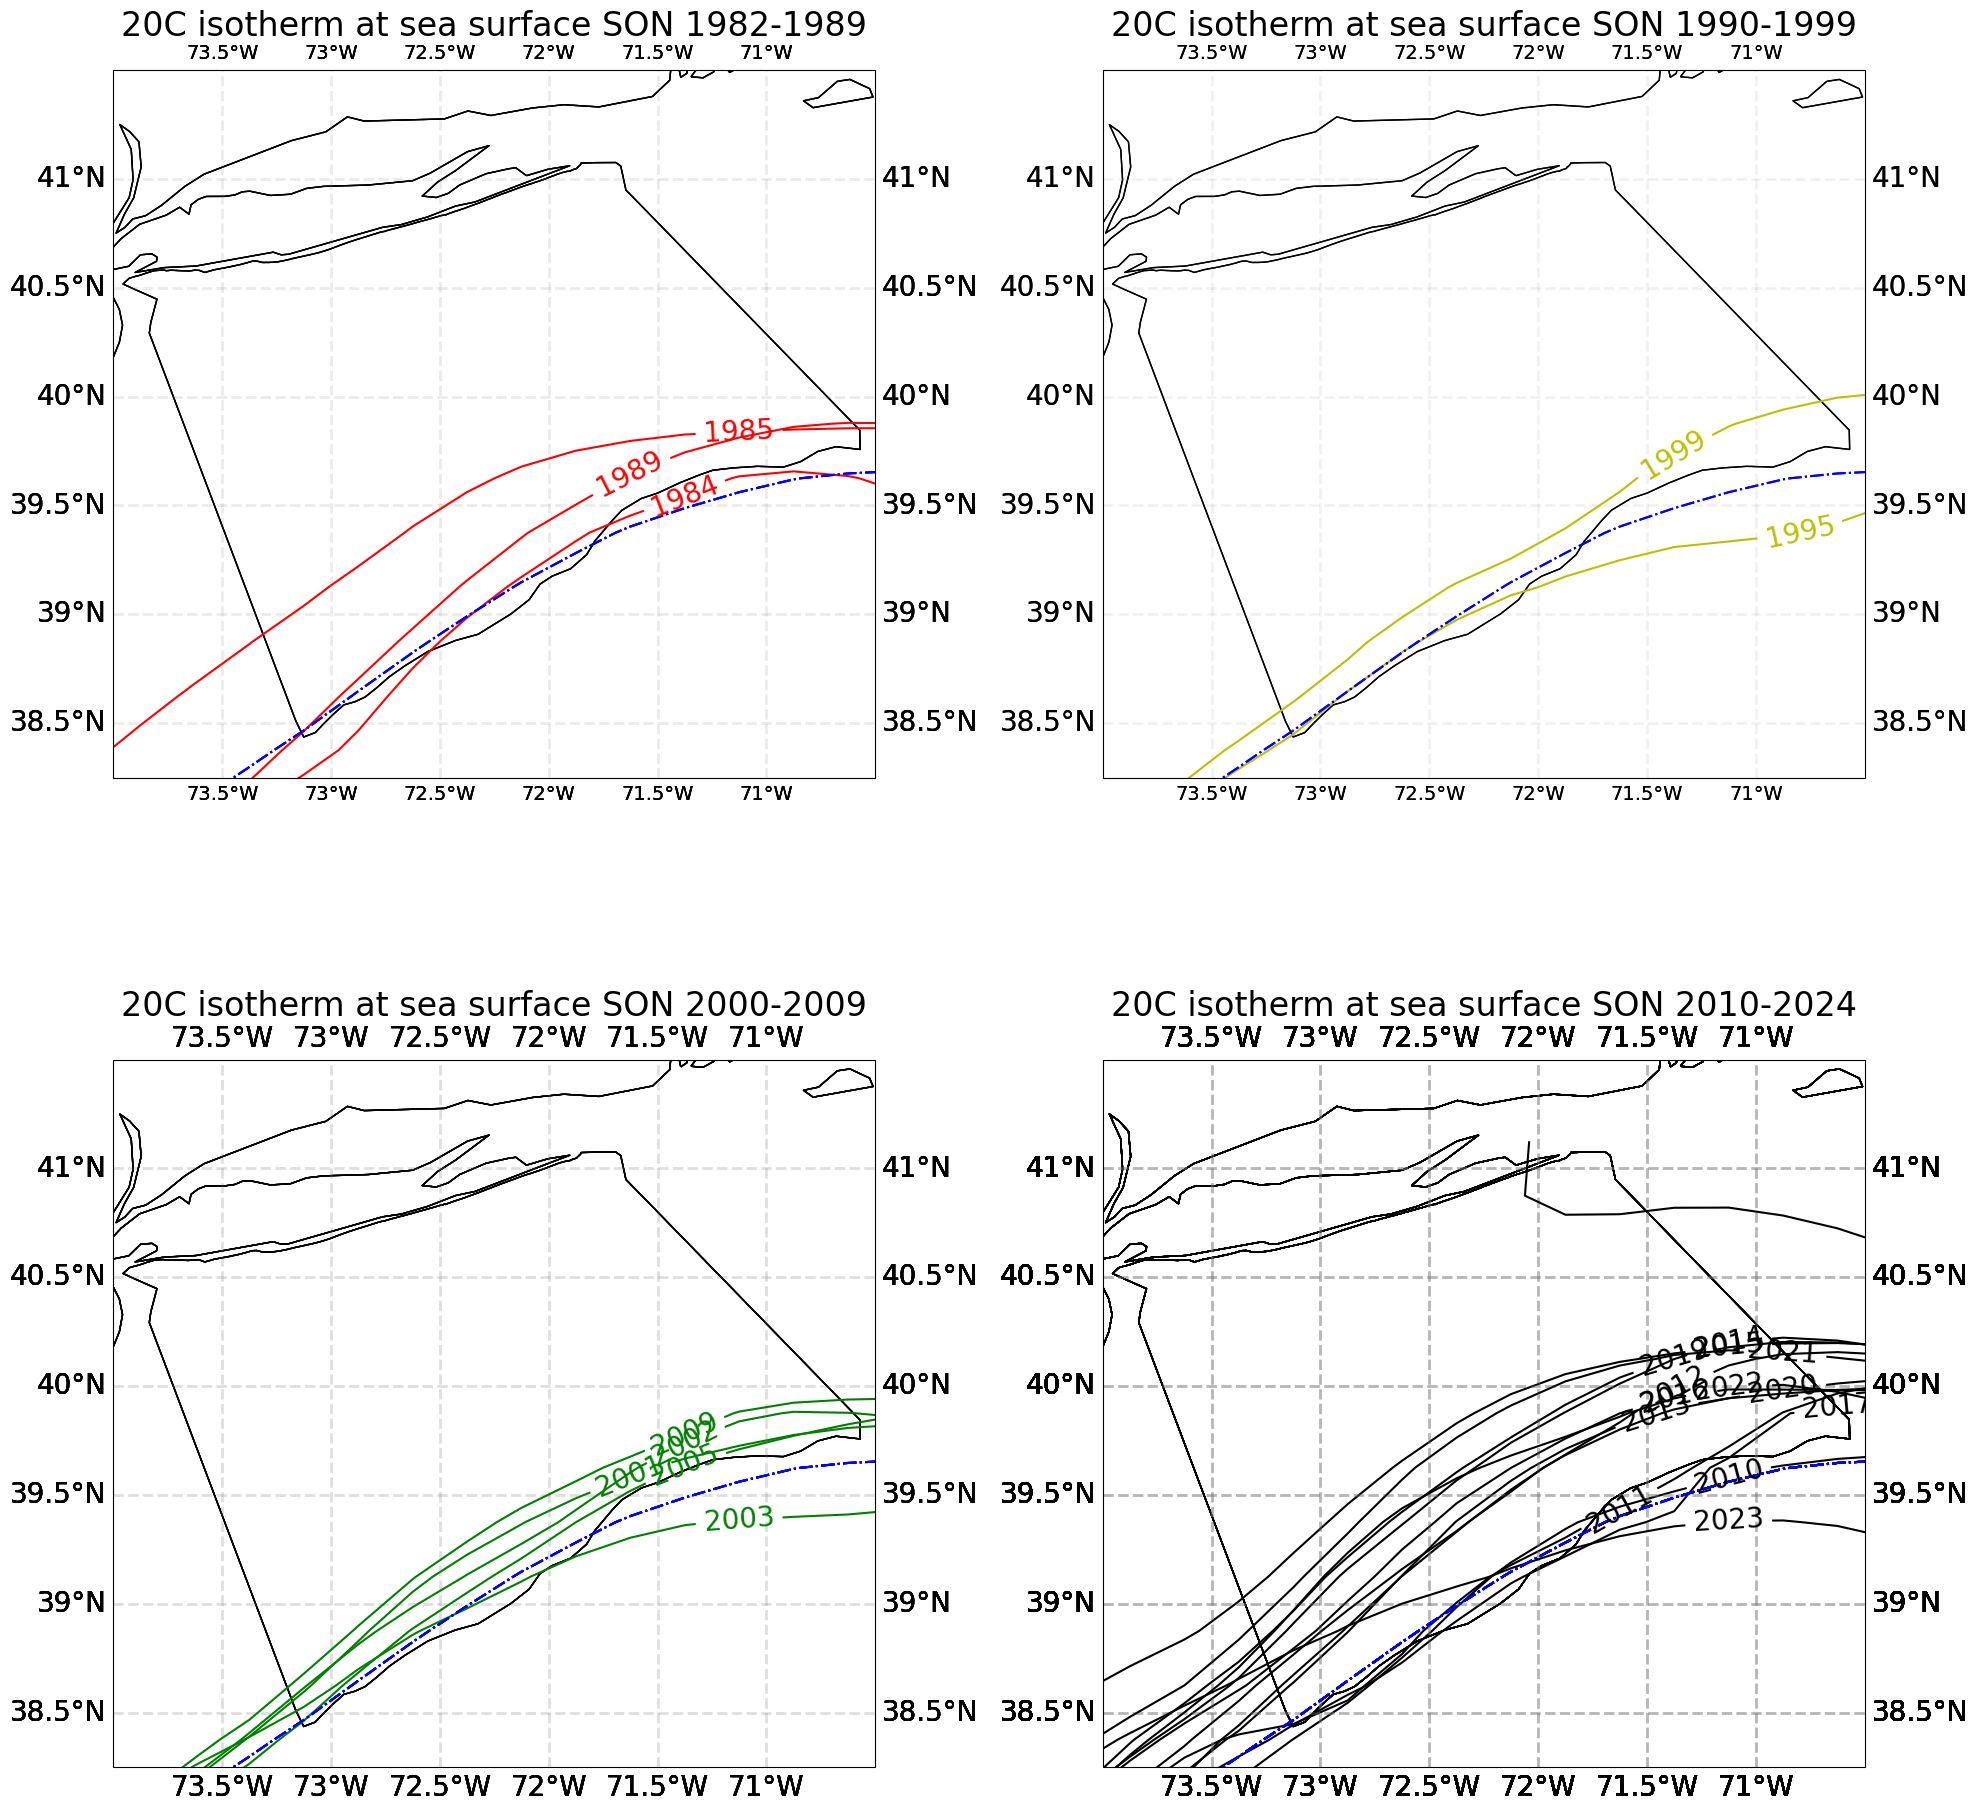

In [53]:
%matplotlib inline
fig,ax = plt.subplots(ncols = 2, nrows = 2, figsize = [20,20],subplot_kw={'projection': ccrs.PlateCarree()})
for i in range(len(SON)):
    if np.nanmax(test_seas[SON[i],:,:]) >= 20:
        text = np.arange(1982,2025,1)
        text2 = str(text[i])
        if text[i]<1990:
            extent = [286,289.5,38.25,41.5]
            gl = ax[0,0].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.05, linestyle='--')
            gl.xlabels_top = False
            gl.xlabels_bottom = False
            gl.ylabels_right = False
            gl.ylabel_style = {'size': 20, 'color': 'k'}
            ax[0,0].set_extent(extent)
            ax[0,0].coastlines(resolution='50m')
            # CS = ax[0,0].contour(sst.longitude[25:40],sst.latitude,sst_seas[SON[i],:,25:40],levels = [20],colors='r',transform=ccrs.PlateCarree())
            # ax[0,0].contour(seas.longitude[25:40],seas.latitude, seas.sst[3,0,:,25:40],levels=[20], colors = 'b',linestyles = 'dashdot')
            CS = ax[0,0].contour(sst.longitude,sst.latitude,sst_seas[SON[i],:,:],levels = [20],colors='r',transform=ccrs.PlateCarree())
            ax[0,0].contour(seas.longitude,seas.latitude, seas.sst[3,0,:,:],levels=[20], colors = 'b',linestyles = 'dashdot')
            ax[0,0].clabel(CS, fontsize=20, inline=1, fmt=text2)
            #ax[0,0].clabel(CS2, fontsize = 16, inline = 1, fmt='mean')
            ax[0,0].add_geometries(NYB.geometry,
                  ccrs.PlateCarree(),
                  facecolor='none', edgecolor = 'k')#hatch='xxxx')
            ax[0,0].set_title('20C isotherm at sea surface SON 1982-1989', fontsize = 24)
        if text[i]>=1990 and text[i]<2000:
            extent = [286,289.5,38.25,41.5]
            ax[0,1].set_extent(extent)
            gl = ax[0,1].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.05, linestyle='--')
            gl.xlabels_top = False
            gl.xlabels_bottom = False
            gl.ylabels_right = False
            gl.ylabels_left = False
            gl.ylabel_style = {'size': 20, 'color': 'k'}
            ax[0,1].coastlines(resolution='50m')
            # CS = ax[0,1].contour(sst.longitude[25:40],sst.latitude,sst_seas[SON[i],:,25:40],levels = [20],colors='y')
            # ax[0,1].contour(seas.longitude[25:40],seas.latitude, seas.sst[3,0,:,25:40],levels=[20], colors = 'b',linestyles = 'dashdot')
            CS = ax[0,1].contour(sst.longitude,sst.latitude,sst_seas[SON[i],:,:],levels = [20],colors='y')
            ax[0,1].contour(seas.longitude,seas.latitude, seas.sst[3,0,:,:],levels=[20], colors = 'b',linestyles = 'dashdot')
            ax[0,1].clabel(CS, fontsize=20, inline=1, fmt=text2)
            ax[0,1].add_geometries(NYB.geometry,
                    ccrs.PlateCarree(),
                    facecolor='none', edgecolor = 'k')#hatch='xxxx')
            ax[0,1].set_title('20C isotherm at sea surface SON 1990-1999', fontsize = 24)
        if text[i]>=2000 and text[i]<2010:
            extent = [286,289.5,38.25,41.5]
            ax[1,0].set_extent(extent)
            gl = ax[1,0].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.05, linestyle='--')
            gl.xlabels_top = False
            gl.xlabels_bottom = True
            gl.ylabels_right = False
            gl.ylabels_left = True
            gl.ylabel_style = {'size': 20, 'color': 'k'}
            gl.xlabel_style = {'size': 20, 'color': 'k'}
            ax[1,0].coastlines(resolution='50m')
            # CS = ax[1,0].contour(sst.longitude[25:40],sst.latitude,sst_seas[SON[i],:,25:40],levels = [20],colors='g')
            # ax[1,0].contour(seas.longitude[25:40],seas.latitude, seas.sst[3,0,:,25:40],levels=[20], colors = 'b',linestyles = 'dashdot')
            CS = ax[1,0].contour(sst.longitude,sst.latitude,sst_seas[SON[i],:,:],levels = [20],colors='g')
            ax[1,0].contour(seas.longitude,seas.latitude, seas.sst[3,0,:,:],levels=[20], colors = 'b',linestyles = 'dashdot')
            ax[1,0].clabel(CS, fontsize=20, inline=1, fmt=text2)
            ax[1,0].add_geometries(NYB.geometry,
                  ccrs.PlateCarree(),
                  facecolor='none', edgecolor = 'k')#hatch='xxxx')
            ax[1,0].set_title('20C isotherm at sea surface SON 2000-2009', fontsize = 24)
        if text[i]>=2010:
            extent = [286,289.5,38.25,41.5]
            ax[1,1].set_extent(extent)
            gl = ax[1,1].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.05, linestyle='--')
            gl.xlabels_top = False
            gl.xlabels_bottom = True
            gl.ylabels_right = False
            gl.ylabels_left = False
            gl.ylabel_style = {'size': 20, 'color': 'k'}
            gl.xlabel_style = {'size': 20, 'color': 'k'}
            ax[1,1].coastlines(resolution='50m')
            # CS = ax[1,1].contour(sst.longitude[25:40],sst.latitude,sst_seas[SON[i],:,25:40],levels = [20],colors='k')
            # ax[1,1].contour(seas.longitude[25:40],seas.latitude, seas.sst[3,0,:,25:40],levels=[20], colors = 'b',linestyles = 'dashdot')
            CS = ax[1,1].contour(sst.longitude,sst.latitude,sst_seas[SON[i],:,:],levels = [20],colors='k')
            ax[1,1].contour(seas.longitude,seas.latitude, seas.sst[3,0,:,:],levels=[20], colors = 'b',linestyles = 'dashdot')
            ax[1,1].clabel(CS, fontsize=20, inline=1, fmt=text2)
            ax[1,1].add_geometries(NYB.geometry,
                  ccrs.PlateCarree(),
                  facecolor='none', edgecolor = 'k')#hatch='xxxx')
            ax[1,1].set_title('20C isotherm at sea surface SON 2010-2024', fontsize = 24)

plt.tight_layout()

## Figures for 2024 report

In [56]:
sst.latitude

<xarray.DataArray 'latitude' (latitude: 57)>
array([32.125, 32.375, 32.625, 32.875, 33.125, 33.375, 33.625, 33.875, 34.125,
       34.375, 34.625, 34.875, 35.125, 35.375, 35.625, 35.875, 36.125, 36.375,
       36.625, 36.875, 37.125, 37.375, 37.625, 37.875, 38.125, 38.375, 38.625,
       38.875, 39.125, 39.375, 39.625, 39.875, 40.125, 40.375, 40.625, 40.875,
       41.125, 41.375, 41.625, 41.875, 42.125, 42.375, 42.625, 42.875, 43.125,
       43.375, 43.625, 43.875, 44.125, 44.375, 44.625, 44.875, 45.125, 45.375,
       45.625, 45.875, 46.125], dtype=float32)
Coordinates:
  * latitude  (latitude) float32 32.12 32.38 32.62 32.88 ... 45.62 45.88 46.12
Attributes:
    _CoordinateAxisType:  Lat
    actual_range:         [32.125 46.125]
    axis:                 Y
    grids:                Uniform grid from -89.875 to 89.875 by 0.25
    ioos_category:        Location
    long_name:            Latitude
    standard_name:        latitude
    units:                degrees_north

/var/folders/1w/tsz98z_x4q3_nd__h3c3cr7r0000gn/T/ipykernel_83888/1002720198.py:19: RuntimeWarning: Mean of empty slice
  CS1 = ax.contour(seas.longitude[25:40],seas.latitude, np.nanmean(sst_seas[JJA[a:b+1],:,25:40],0),levels=[20], colors = 'c',linewidths = 5)
/var/folders/1w/tsz98z_x4q3_nd__h3c3cr7r0000gn/T/ipykernel_83888/1002720198.py:29: RuntimeWarning: Mean of empty slice
  CS2 = ax.contour(seas.longitude[25:40],seas.latitude, np.nanmean(sst_seas[JJA[a:b+1],:,25:40],0),levels=[20], colors = 'g',linewidths = 5)
/var/folders/1w/tsz98z_x4q3_nd__h3c3cr7r0000gn/T/ipykernel_83888/1002720198.py:39: RuntimeWarning: Mean of empty slice
  CS3 = ax.contour(seas.longitude[25:40],seas.latitude, np.nanmean(sst_seas[JJA[a:b+1],:,25:40],0),levels=[20], colors = 'orange',linewidths = 5)
/var/folders/1w/tsz98z_x4q3_nd__h3c3cr7r0000gn/T/ipykernel_83888/1002720198.py:49: RuntimeWarning: Mean of empty slice
  CS4 = ax.contour(seas.longitude[25:40],seas.latitude, np.nanmean(sst_seas[JJA[a:b+1],:,25:40],

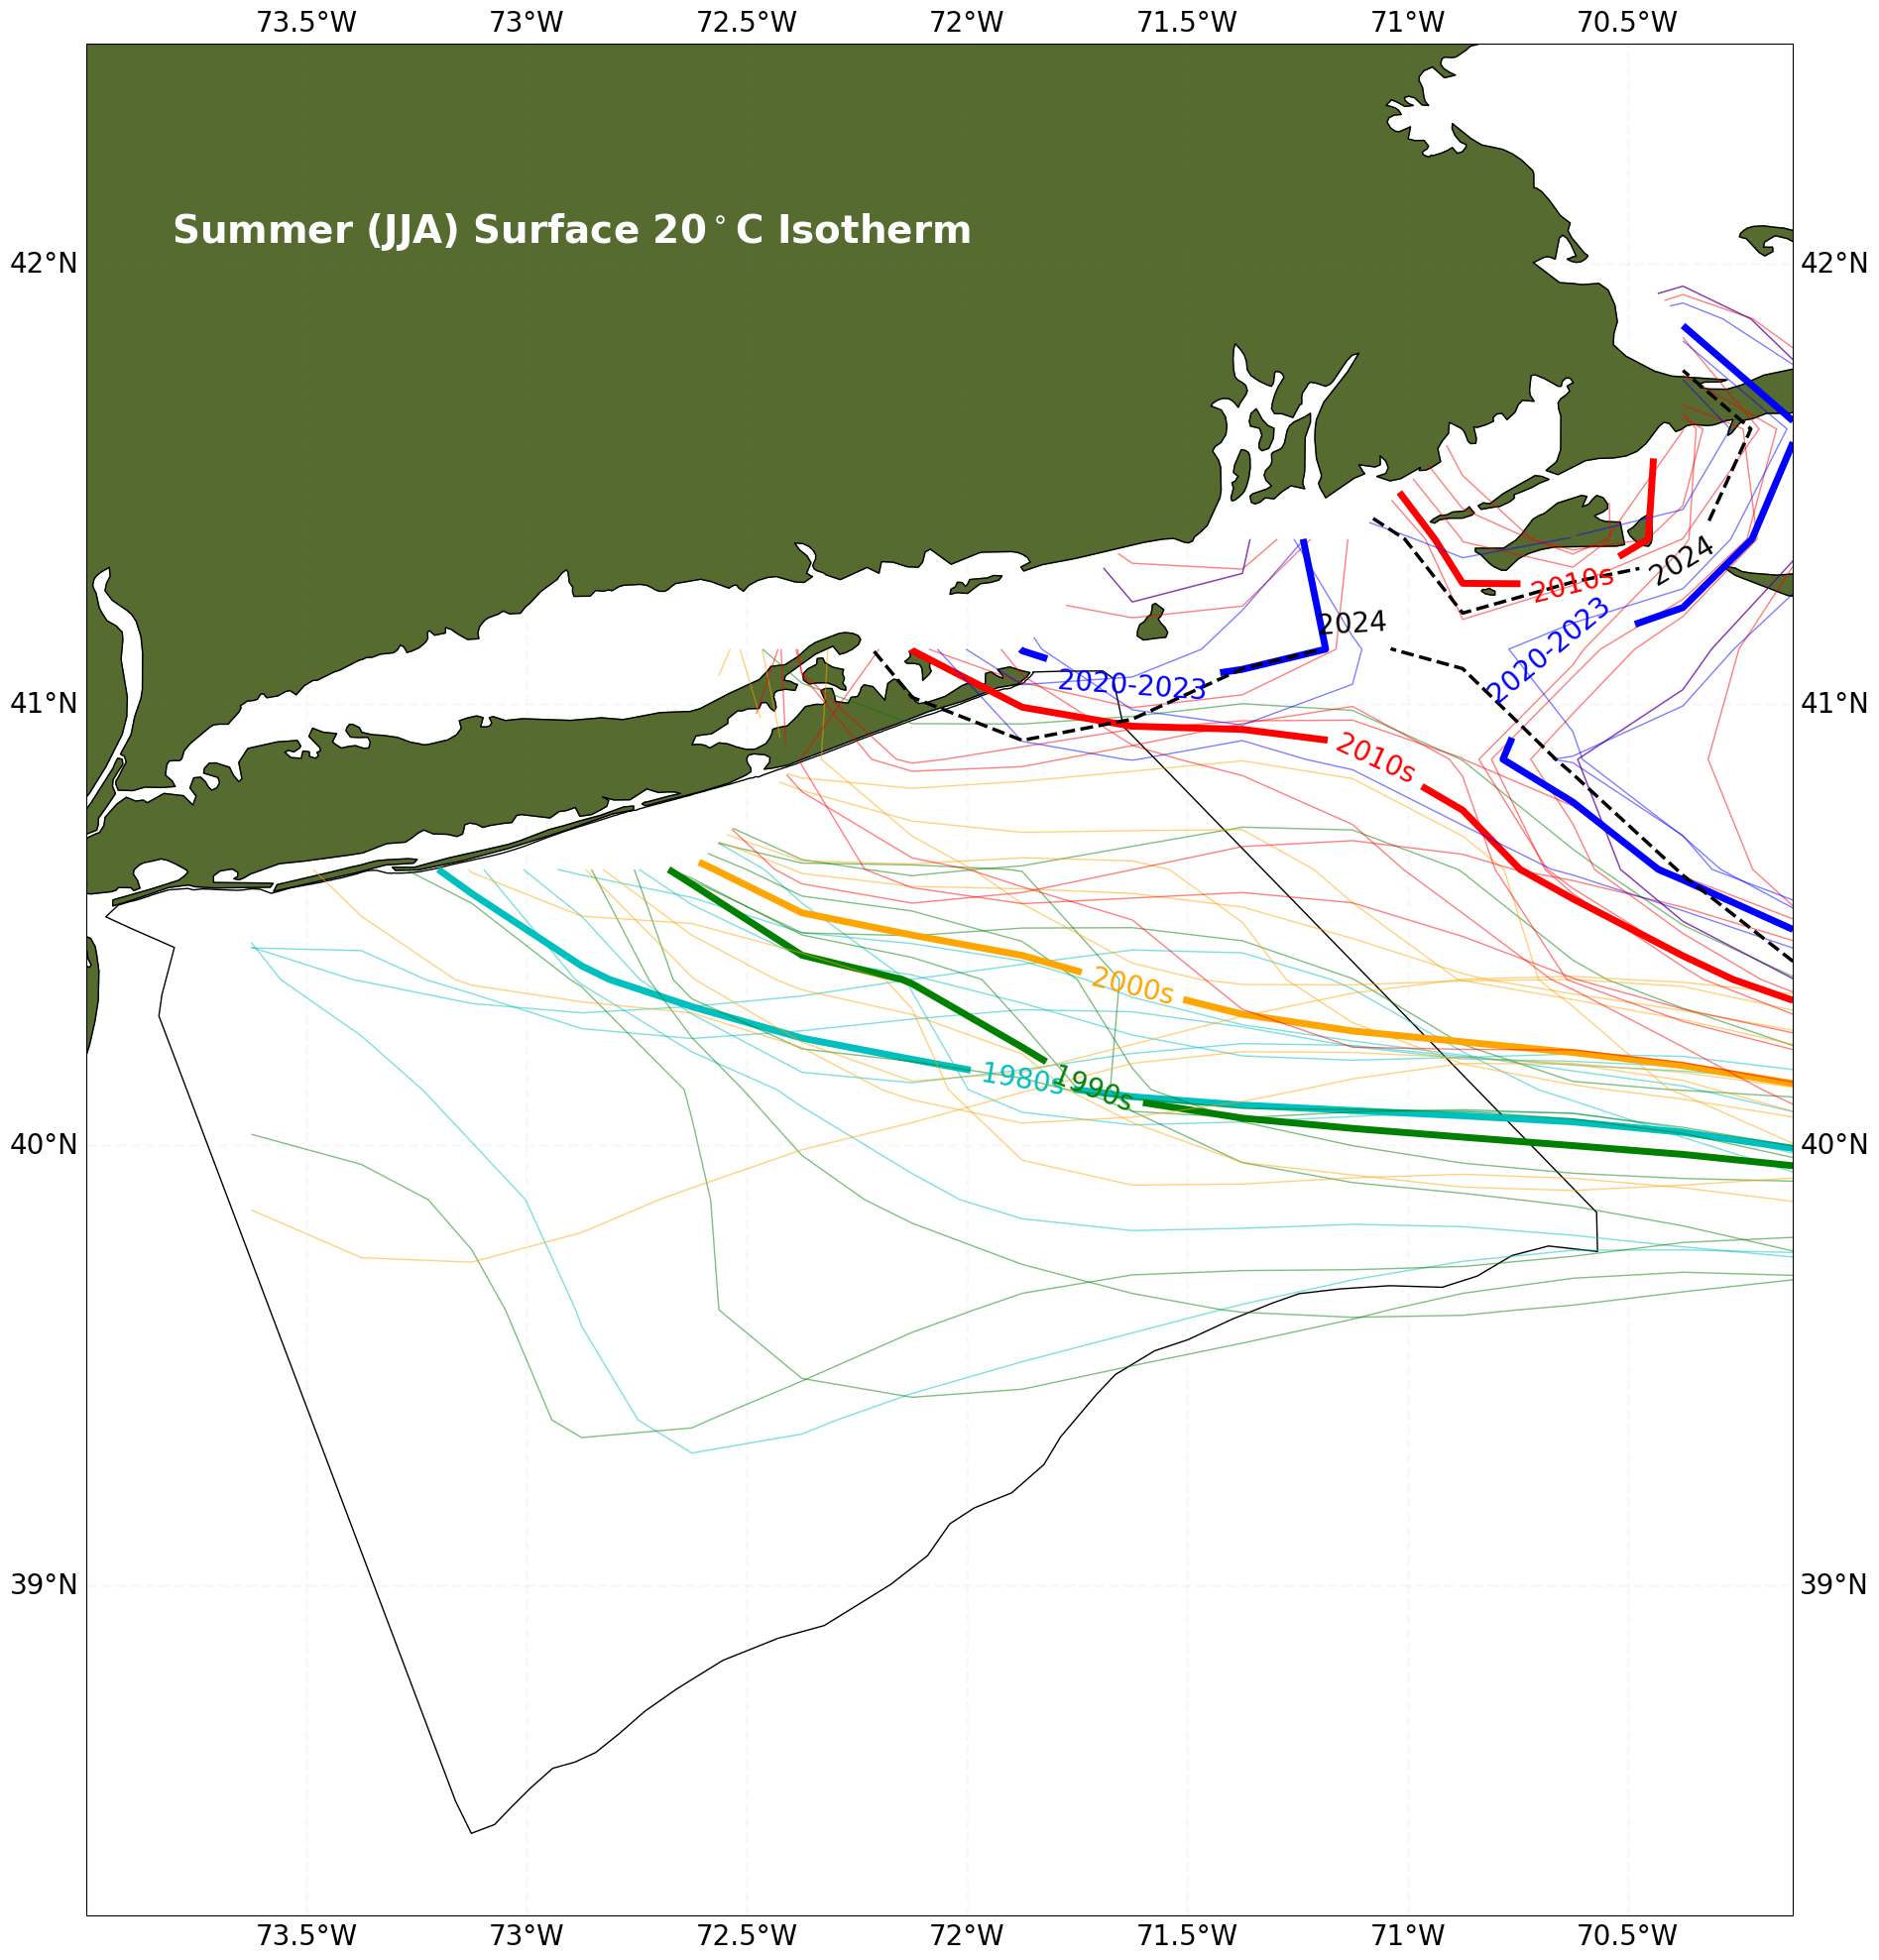

In [62]:
fig,ax = plt.subplots(ncols = 1, nrows = 1, figsize = [20,20],subplot_kw={'projection': ccrs.PlateCarree()})
extent = [286,289.875,38.25,42.5]
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.05, linestyle='--')
ax.coastlines(resolution='10m')
ax.set_extent(extent)
ax.add_feature(cartopy.feature.LAND, color = 'darkolivegreen')
ax.add_geometries(NYB.geometry,
                  ccrs.PlateCarree(),
                  facecolor='none', edgecolor = 'k')
for i in range(len(JJA)):
    if np.nanmax(sst_seas[JJA[i],:,:]) >= 20:
        text = np.arange(1982,2025,1)
        text2 = str(text[i])
        if text[i]<1990:
            if text[i] == 1982:
                a = i
            if text[i] == 1989:
                b = i
                CS1 = ax.contour(seas.longitude[25:40],seas.latitude, np.nanmean(sst_seas[JJA[a:b+1],:,25:40],0),levels=[20], colors = 'c',linewidths = 5)
                # CS1 = ax.contour(seas.longitude,seas.latitude, np.nanmean(sst_seas[JJA[a:b+1],:,:],0),levels=[20], colors = 'c',linewidths = 5)
                ax.clabel(CS1, fontsize = 20, inline =1, fmt='1980s')
            ax.contour(sst.longitude[25:40],sst.latitude,sst_seas[JJA[i],:,25:40],levels = [20],colors='c',alpha = 0.5, linewidths = 1,transform=ccrs.PlateCarree())
            # ax.contour(sst.longitude,sst.latitude,sst_seas[JJA[i],:,:],levels = [20],colors='c',alpha = 0.5, linewidths = 1,transform=ccrs.PlateCarree())
        if text[i]>=1990 and text[i]<2000:
            if text[i] == 1990:
                a = i
            if text[i] == 1999:
                b = i
                CS2 = ax.contour(seas.longitude[25:40],seas.latitude, np.nanmean(sst_seas[JJA[a:b+1],:,25:40],0),levels=[20], colors = 'g',linewidths = 5)
                # CS2 = ax.contour(seas.longitude,seas.latitude, np.nanmean(sst_seas[JJA[a:b+1],:,:],0),levels=[20], colors = 'g',linewidths = 5)
                ax.clabel(CS2, fontsize = 20, inline =1, fmt='1990s')            
            ax.contour(sst.longitude[25:40],sst.latitude,sst_seas[JJA[i],:,25:40],levels = [20],colors='g',alpha = 0.5, linewidths = 1,transform=ccrs.PlateCarree())
            # ax.contour(sst.longitude,sst.latitude,sst_seas[JJA[i],:,:],levels = [20],colors='g',alpha = 0.5, linewidths = 1,transform=ccrs.PlateCarree())
        if text[i]>=2000 and text[i]<2010:
            if text[i] == 2000:
                a = i
            if text[i] == 2009:
                b = i
                CS3 = ax.contour(seas.longitude[25:40],seas.latitude, np.nanmean(sst_seas[JJA[a:b+1],:,25:40],0),levels=[20], colors = 'orange',linewidths = 5)
                # CS3 = ax.contour(seas.longitude,seas.latitude, np.nanmean(sst_seas[JJA[a:b+1],:,:],0),levels=[20], colors = 'orange',linewidths = 5)
                ax.clabel(CS3, fontsize = 20, inline =1, fmt='2000s')            
            ax.contour(sst.longitude[25:40],sst.latitude,sst_seas[JJA[i],:,25:40],levels = [20],colors='orange',alpha = 0.5, linewidths = 1,transform=ccrs.PlateCarree())
            # ax.contour(sst.longitude,sst.latitude,sst_seas[JJA[i],:,:],levels = [20],colors='orange',alpha = 0.5, linewidths = 1,transform=ccrs.PlateCarree())
        if text[i]>=2010 and text[i] < 2021:
            if text[i] == 2010:
                a = i
            if text[i] == 2019:
                b = i
                CS4 = ax.contour(seas.longitude[25:40],seas.latitude, np.nanmean(sst_seas[JJA[a:b+1],:,25:40],0),levels=[20], colors = 'r',linewidths = 5)
                # CS4 = ax.contour(seas.longitude,seas.latitude, np.nanmean(sst_seas[JJA[a:b+1],:,:],0),levels=[20], colors = 'r',linewidths = 5)
                ax.clabel(CS4, fontsize = 20, inline =1, fmt='2010s')            
            ax.contour(sst.longitude[25:40],sst.latitude,sst_seas[JJA[i],:,25:40],levels = [20],colors='r',alpha = 0.5, linewidths = 1,transform=ccrs.PlateCarree())
            # ax.contour(sst.longitude,sst.latitude,sst_seas[JJA[i],:,:],levels = [20],colors='r',alpha = 0.5, linewidths = 1,transform=ccrs.PlateCarree())
        #if text[i] ==2021:
        #    CS = ax.contour(sst.longitude[25:40],sst.latitude,sst_seas[JJA[i],:,25:40],levels = [20],colors='k',linewidths = 2.5,transform=ccrs.PlateCarree())
        #    # CS = ax.contour(sst.longitude,sst.latitude,sst_seas[JJA[i],:,:],levels = [20],colors='k',linewidths = 2.5,transform=ccrs.PlateCarree())
        #    ax.clabel(CS, fontsize=20, inline=1, fmt=text2)
        #if text[i] ==2022:
        #    CS = ax.contour(sst.longitude[25:40],sst.latitude,sst_seas[JJA[i],:,25:40],levels = [20],colors='k',linewidths = 2.5,transform=ccrs.PlateCarree(), linestyles = '-.')
        #    # CS = ax.contour(sst.longitude,sst.latitude,sst_seas[JJA[i],:,:],levels = [20],colors='k',linewidths = 2.5,transform=ccrs.PlateCarree(), linestyles = '-.')
        #    ax.clabel(CS, fontsize=20, inline=1, fmt=text2)
        #if text[i] ==2023:
        #    CS = ax.contour(sst.longitude[25:40],sst.latitude,sst_seas[JJA[i],:,25:40],levels = [20],colors='k',linewidths = 2.5,transform=ccrs.PlateCarree(), linestyles = 'dotted')
        #    # CS = ax.contour(sst.longitude,sst.latitude,sst_seas[JJA[i],:,:],levels = [20],colors='k',linewidths = 2.5,transform=ccrs.PlateCarree(), linestyles = 'dotted')
        #    ax.clabel(CS, fontsize=20, inline=1, fmt=text2)
        #if text[i] ==2024:
        #    CS = ax.contour(sst.longitude[25:40],sst.latitude,sst_seas[JJA[i],:,25:40],levels = [20],colors='k',linewidths = 2.5,transform=ccrs.PlateCarree(), linestyles = 'dotted')
        #    # CS = ax.contour(sst.longitude,sst.latitude,sst_seas[JJA[i],:,:],levels = [20],colors='k',linewidths = 2.5,transform=ccrs.PlateCarree(), linestyles = 'dashed')
        #    ax.clabel(CS, fontsize=20, inline=1, fmt=text2)    
        if text[i]>=2020 and text[i] < 2024:
            if text[i] == 2020:
                a = i
            if text[i] == 2023:
                b = i
                CS5 = ax.contour(seas.longitude[25:40],seas.latitude, np.nanmean(sst_seas[JJA[a:b+1],:,25:40],0),levels=[20], colors = 'b',linewidths = 5)
                ax.clabel(CS5, fontsize = 20, inline =1, fmt='2020-2023')            
            ax.contour(sst.longitude[25:40],sst.latitude,sst_seas[JJA[i],:,25:40],levels = [20],colors='b',alpha = 0.5, linewidths = 1,transform=ccrs.PlateCarree())
        if text[i] == 2024:
            CS = ax.contour(sst.longitude[25:40],sst.latitude,sst_seas[JJA[i],:,25:40],levels = [20],colors='k',linewidths = 2.5,transform=ccrs.PlateCarree(), linestyles = 'dashed')
            ax.clabel(CS, fontsize=20, inline=1, fmt=text2)  
               
ax.text(0.05, 0.9, r'Summer (JJA) Surface 20$^\circ$C Isotherm', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize = 28, color = 'white', weight = 'bold')

gl.xlabels_top = False
gl.xlabels_bottom = True
gl.ylabels_right = False
gl.ylabel_style = {'size': 20, 'color': 'k'}
gl.xlabel_style = {'size': 20, 'color': 'k'}
plt.tight_layout()
# plt.show()
plt.savefig("/Users/ian/Documents/GitHub/NYB_Indicators_Calculations-main/IJM_code/Figures_2024/Isotherm_Summer.png", dpi=300, bbox_inches='tight')




In [131]:
range(len(SON))

range(0, 43)

/var/folders/1w/tsz98z_x4q3_nd__h3c3cr7r0000gn/T/ipykernel_83888/2594785396.py:21: RuntimeWarning: Mean of empty slice
  CS1 = ax.contour(seas.longitude[25:40], seas.latitude, np.nanmean(sst_seas[SON[a:b+1], :, 25:40], 0), levels=[20], colors='c', linewidths=5)
/var/folders/1w/tsz98z_x4q3_nd__h3c3cr7r0000gn/T/ipykernel_83888/2594785396.py:33: RuntimeWarning: Mean of empty slice
  CS2 = ax.contour(seas.longitude[25:40],seas.latitude, np.nanmean(sst_seas[SON[a:b+1],:,25:40],0),levels=[20], colors = 'g',linewidths = 5)
/var/folders/1w/tsz98z_x4q3_nd__h3c3cr7r0000gn/T/ipykernel_83888/2594785396.py:42: RuntimeWarning: Mean of empty slice
  CS3 = ax.contour(seas.longitude[25:40],seas.latitude, np.nanmean(sst_seas[SON[a:b+1],:,25:40],0),levels=[20], colors = 'orange',linewidths = 5)
/var/folders/1w/tsz98z_x4q3_nd__h3c3cr7r0000gn/T/ipykernel_83888/2594785396.py:51: RuntimeWarning: Mean of empty slice
  CS4 = ax.contour(seas.longitude[25:40],seas.latitude, np.nanmean(sst_seas[SON[a:b+1],:,25:40

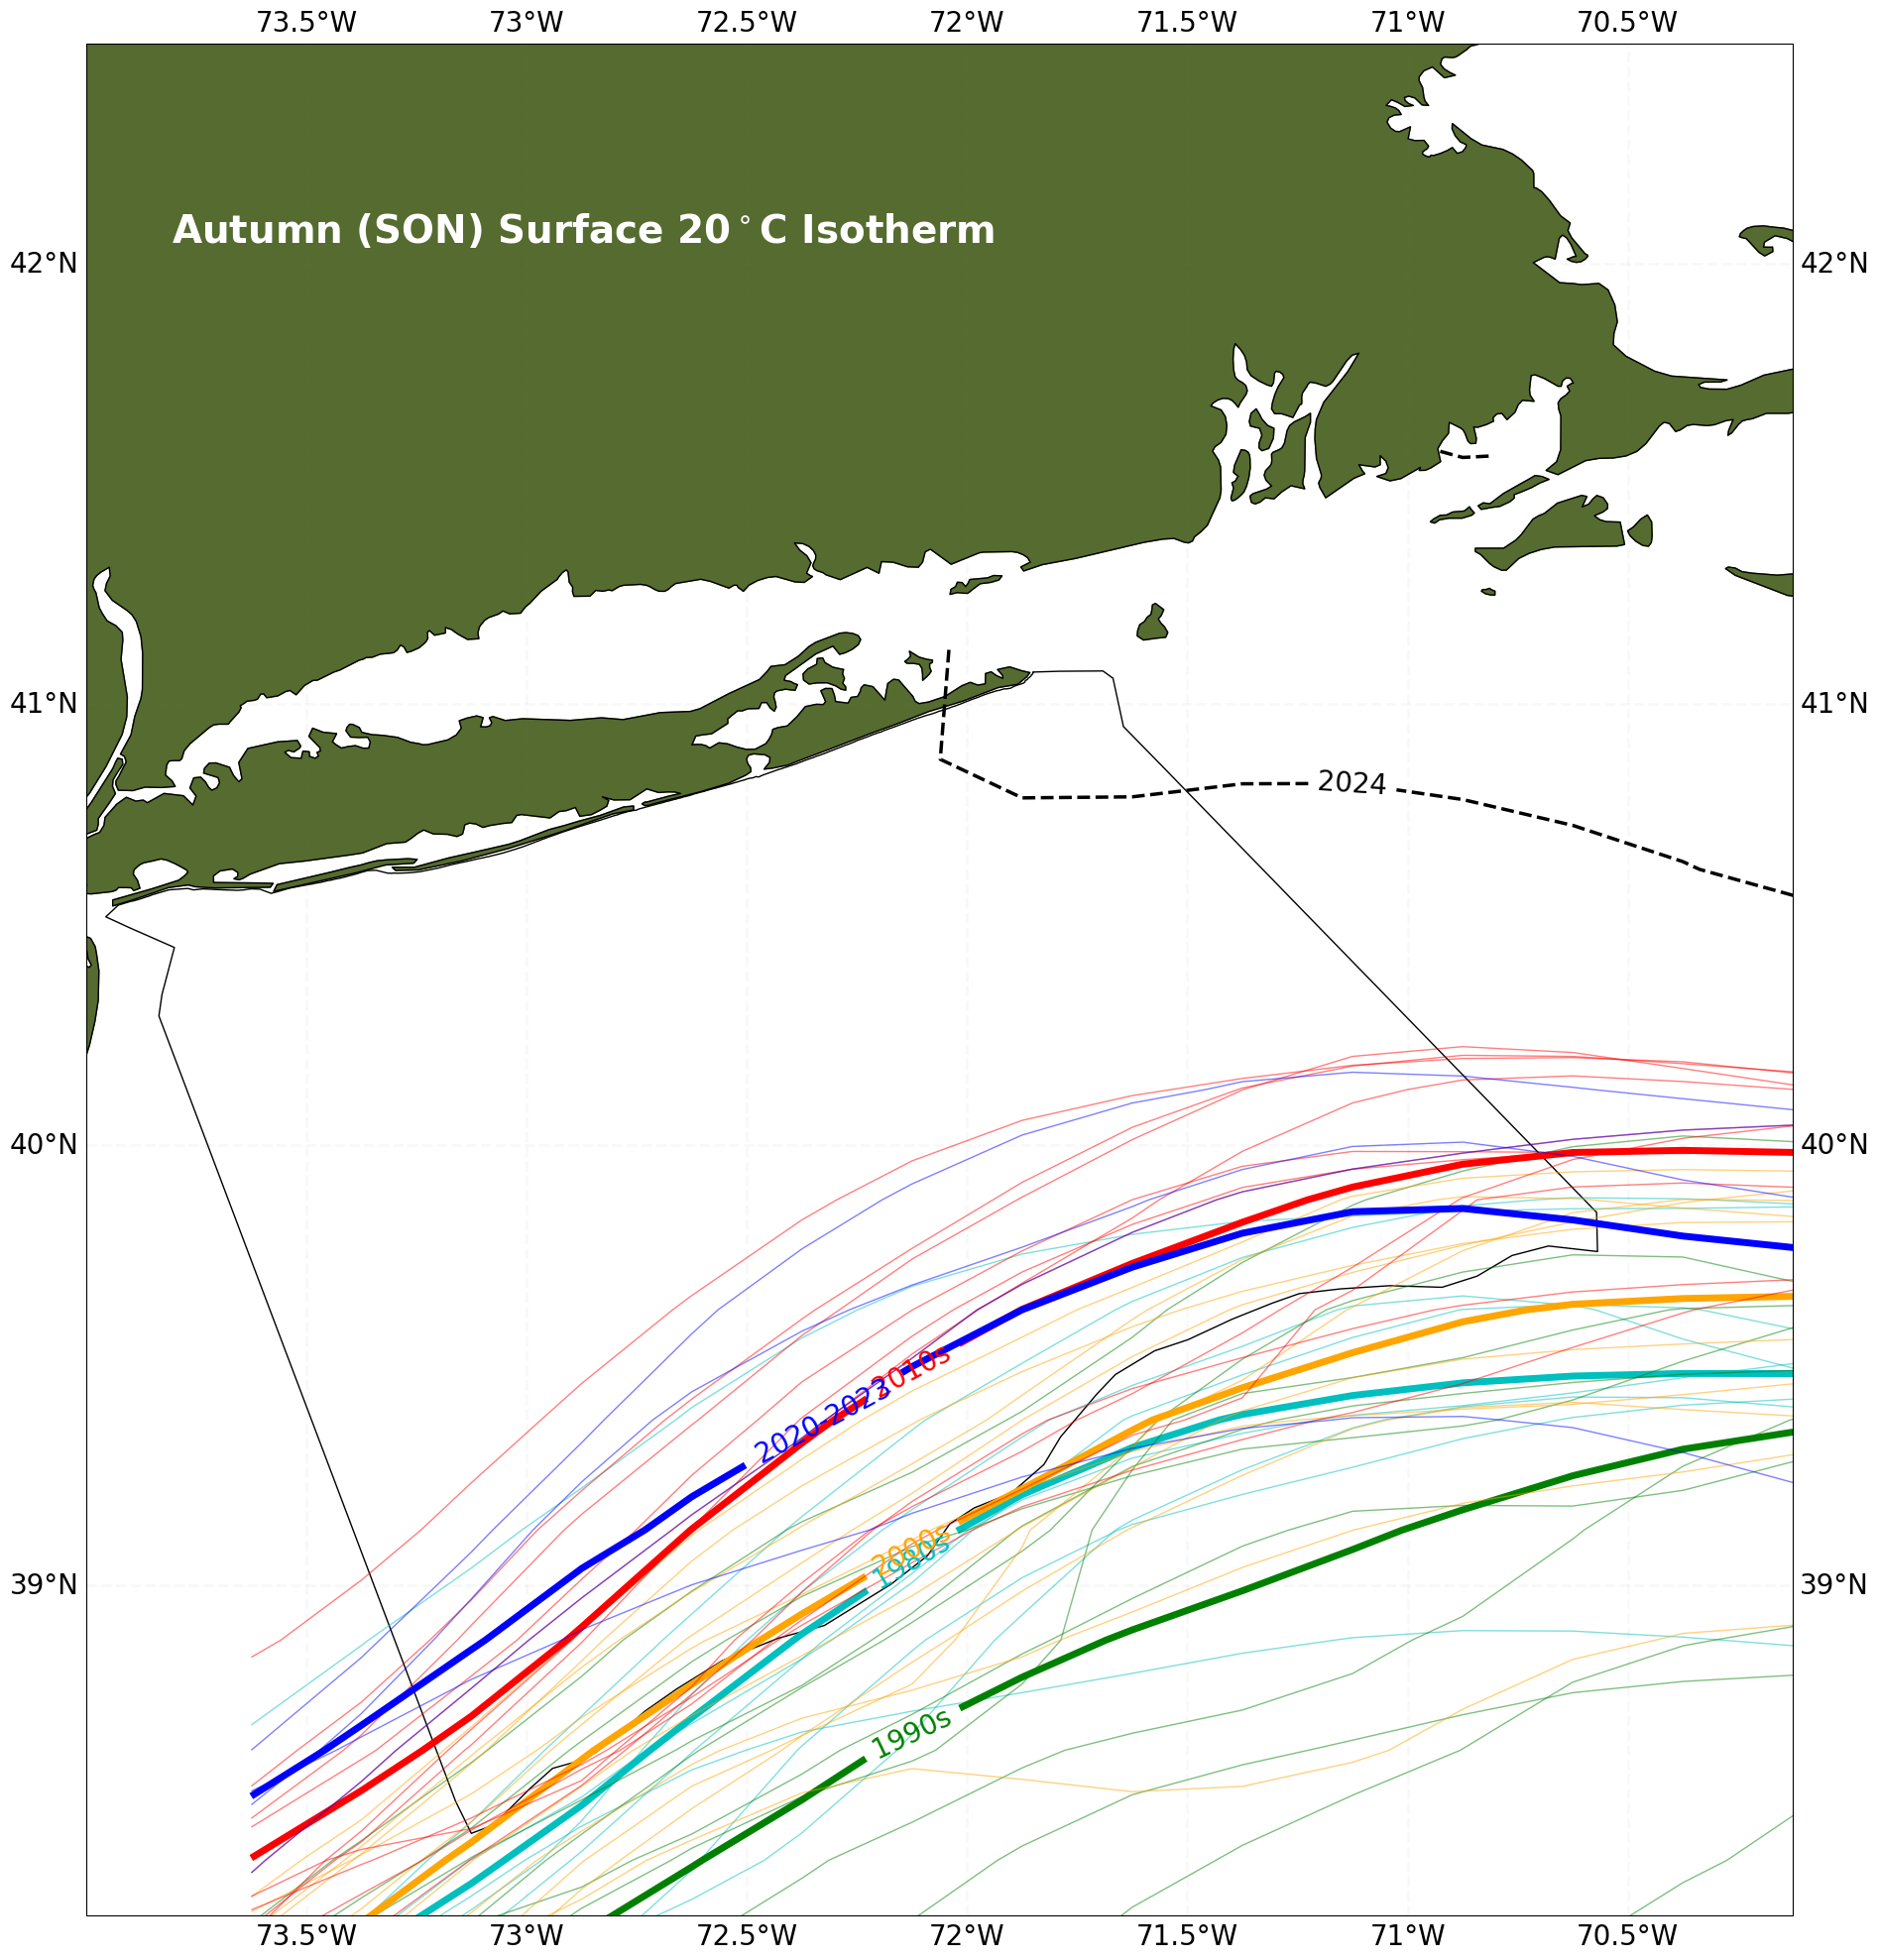

In [64]:
fig,ax = plt.subplots(ncols = 1, nrows = 1, figsize = [20,20],subplot_kw={'projection': ccrs.PlateCarree()})
extent = [286,289.875,38.25,42.5]
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.05, linestyle='--')
ax.coastlines(resolution='10m')
ax.set_extent(extent)
ax.add_feature(cartopy.feature.LAND, color = 'darkolivegreen')
ax.add_geometries(NYB.geometry,
                  ccrs.PlateCarree(),
                  facecolor='none', edgecolor = 'k')
for i in range(len(SON)):
    if np.nanmax(sst_seas[SON[i],:,:]) >= 20:
        text = np.arange(1982,2025,1)
        text2 = str(text[i])
        if text[i]<1990:
            if text[i] == 1982:
                a = i
            if text[i] == 1989:
                b = i

                if not np.isnan(sst_seas[SON[a:b+1], :, 25:40]).all():
                    CS1 = ax.contour(seas.longitude[25:40], seas.latitude, np.nanmean(sst_seas[SON[a:b+1], :, 25:40], 0), levels=[20], colors='c', linewidths=5)
                    ax.clabel(CS1, fontsize=20, inline=1, fmt='1980s')
                    
                # CS1 = ax.contour(seas.longitude[25:40],seas.latitude, np.nanmean(sst_seas[SON[a:b+1],:,25:40],0),levels=[20], colors = 'c',linewidths = 5)
                # ax.clabel(CS1, fontsize = 20, inline =1, fmt='1980s')
            ax.contour(sst.longitude[25:40],sst.latitude,sst_seas[SON[i],:,25:40],levels = [20],colors='c',alpha = 0.5, linewidths = 1,transform=ccrs.PlateCarree())
        if text[i]>=1990 and text[i]<2000:
            if text[i] == 1990:
                a = i
            if text[i] == 1999:
                b = i
                if not np.isnan(sst_seas[SON[a:b+1], :, 25:40]).all():
                    CS2 = ax.contour(seas.longitude[25:40],seas.latitude, np.nanmean(sst_seas[SON[a:b+1],:,25:40],0),levels=[20], colors = 'g',linewidths = 5)
                    ax.clabel(CS2, fontsize = 20, inline =1, fmt='1990s')           
            ax.contour(sst.longitude[25:40],sst.latitude,sst_seas[SON[i],:,25:40],levels = [20],colors='g',alpha = 0.5, linewidths = 1,transform=ccrs.PlateCarree())
        if text[i]>=2000 and text[i]<2010:
            if text[i] == 2000:
                a = i
            if text[i] == 2009:
                b = i
                if not np.isnan(sst_seas[SON[a:b+1], :, 25:40]).all():
                    CS3 = ax.contour(seas.longitude[25:40],seas.latitude, np.nanmean(sst_seas[SON[a:b+1],:,25:40],0),levels=[20], colors = 'orange',linewidths = 5)
                    ax.clabel(CS3, fontsize = 20, inline =1, fmt='2000s')            
            ax.contour(sst.longitude[25:40],sst.latitude,sst_seas[SON[i],:,25:40],levels = [20],colors='orange',alpha = 0.5, linewidths = 1,transform=ccrs.PlateCarree())
        if text[i]>=2010 and text[i] < 2021:
            if text[i] == 2010:
                a = i
            if text[i] == 2019:
                b = i
                if not np.isnan(sst_seas[SON[a:b+1], :, 25:40]).all():
                    CS4 = ax.contour(seas.longitude[25:40],seas.latitude, np.nanmean(sst_seas[SON[a:b+1],:,25:40],0),levels=[20], colors = 'r',linewidths = 5)
                    ax.clabel(CS4, fontsize = 20, inline =1, fmt='2010s')            
            ax.contour(sst.longitude[25:40],sst.latitude,sst_seas[SON[i],:,25:40],levels = [20],colors='r',alpha = 0.5, linewidths = 1,transform=ccrs.PlateCarree())
        # if text[i] ==2021:
        #     CS = ax.contour(sst.longitude[25:40],sst.latitude,sst_seas[SON[i],:,25:40],levels = [20],colors='k',linewidths = 2.5,transform=ccrs.PlateCarree())
        #     ax.clabel(CS, fontsize=20, inline=1, fmt=text2)
        # if text[i] ==2022:
        #     CS = ax.contour(sst.longitude[25:40],sst.latitude,sst_seas[SON[i],:,25:40],levels = [20],colors='k',linewidths = 2.5,transform=ccrs.PlateCarree(), linestyles = '-.')
        #     ax.clabel(CS, fontsize=20, inline=1, fmt=text2)
        # if text[i] ==2023:
        #     CS = ax.contour(sst.longitude[25:40],sst.latitude,sst_seas[SON[i],:,25:40],levels = [20],colors='k',linewidths = 2.5,transform=ccrs.PlateCarree(), linestyles = 'dotted')
        #     ax.clabel(CS, fontsize=20, inline=1, fmt=text2)
        # if text[i] ==2024:
        #     CS = ax.contour(sst.longitude[25:40],sst.latitude,sst_seas[SON[i],:,25:40],levels = [20],colors='k',linewidths = 2.5,transform=ccrs.PlateCarree(), linestyles = 'dotted')
        #     ax.clabel(CS, fontsize=20, inline=1, fmt=text2)
        if text[i]>=2020 and text[i] < 2024:
            if text[i] == 2020:
                a = i
            if text[i] == 2023:
                b = i
                CS5 = ax.contour(seas.longitude[25:40],seas.latitude, np.nanmean(sst_seas[SON[a:b+1],:,25:40],0),levels=[20], colors = 'b',linewidths = 5)
                ax.clabel(CS5, fontsize = 20, inline =1, fmt='2020-2023')            
            ax.contour(sst.longitude[25:40],sst.latitude,sst_seas[SON[i],:,25:40],levels = [20],colors='b',alpha = 0.5, linewidths = 1,transform=ccrs.PlateCarree())
        if text[i] == 2024:
            CS = ax.contour(sst.longitude[25:40],sst.latitude,sst_seas[SON[i],:,25:40],levels = [20],colors='k',linewidths = 2.5,transform=ccrs.PlateCarree(), linestyles = 'dashed')
            ax.clabel(CS, fontsize=20, inline=1, fmt=text2) 
            
# ax.text(0.05, 0.9, 'Autumn (SON) Surface 20$^\circ$C Isotherm', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize = 28, color = 'white', weight = 'bold')
ax.text(0.05, 0.9, r'Autumn (SON) Surface 20$^\circ$C Isotherm', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=28, color='white', weight='bold')


gl.xlabels_top = False
gl.xlabels_bottom = True
gl.ylabels_right = False
gl.ylabel_style = {'size': 20, 'color': 'k'}
gl.xlabel_style = {'size': 20, 'color': 'k'}
plt.tight_layout()
plt.savefig("/Users/ian/Documents/GitHub/NYB_Indicators_Calculations-main/IJM_code/Figures_2024/Isotherm_Autumn.png", dpi=300, bbox_inches='tight')







<>:56: SyntaxWarning: invalid escape sequence '\c'
<>:56: SyntaxWarning: invalid escape sequence '\c'
/var/folders/1w/tsz98z_x4q3_nd__h3c3cr7r0000gn/T/ipykernel_38952/2179514822.py:56: SyntaxWarning: invalid escape sequence '\c'
  ax.text(0.05, 0.9, 'Summer (JAS) Surface 20$^\circ$C Isotherm', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize = 28, color = 'white', weight = 'bold')
/var/folders/1w/tsz98z_x4q3_nd__h3c3cr7r0000gn/T/ipykernel_38952/2179514822.py:19: RuntimeWarning: Mean of empty slice
  CS1 = ax.contour(seas.longitude[25:40],seas.latitude, np.nanmean(sst_seas[JAS[a:b+1],:,25:40],0),levels=[20], colors = 'c',linewidths = 5)
/var/folders/1w/tsz98z_x4q3_nd__h3c3cr7r0000gn/T/ipykernel_38952/2179514822.py:27: RuntimeWarning: Mean of empty slice
  CS2 = ax.contour(seas.longitude[25:40],seas.latitude, np.nanmean(sst_seas[JAS[a:b+1],:,25:40],0),levels=[20], colors = 'g',linewidths = 5)
/var/folders/1w/tsz98z_x4q3_nd__h3c3cr7r0000gn/T/ipykern

IndexError: index 42 is out of bounds for axis 0 with size 42

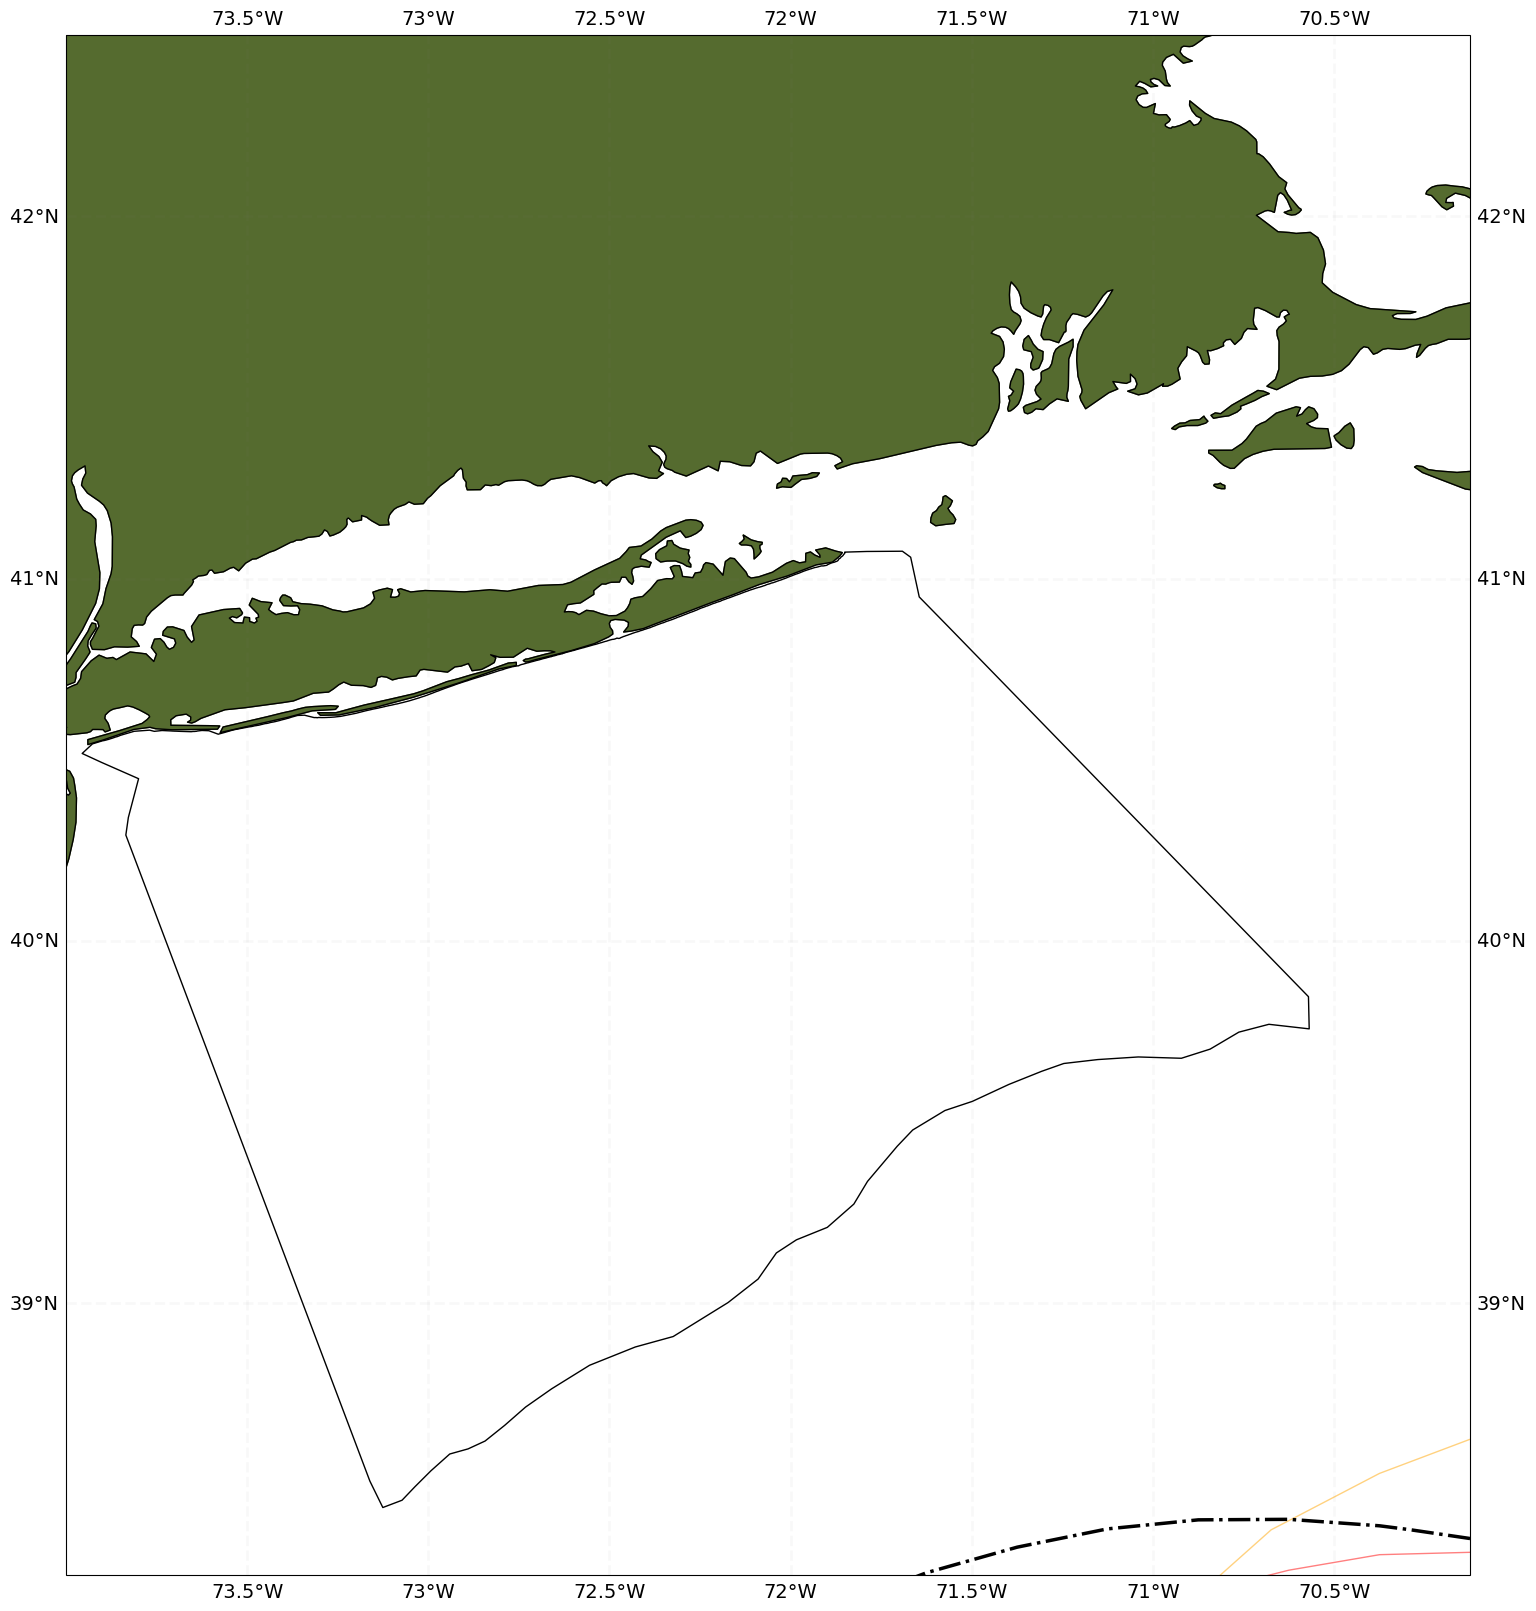

In [77]:
fig,ax = plt.subplots(ncols = 1, nrows = 1, figsize = [20,20],subplot_kw={'projection': ccrs.PlateCarree()})
extent = [286,289.875,38.25,42.5]
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.05, linestyle='--')
ax.coastlines(resolution='10m')
ax.set_extent(extent)
ax.add_feature(cartopy.feature.LAND, color = 'darkolivegreen')
ax.add_geometries(NYB.geometry,
                  ccrs.PlateCarree(),
                  facecolor='none', edgecolor = 'k')
for i in range(len(JAS)):
    if np.nanmax(sst_seas[JAS[i],:,:]) >= 20:
        text = np.arange(1982,2024,1)
        text2 = str(text[i])
        if text[i]<1990:
            if text[i] == 1982:
                a = i
            if text[i] == 1989:
                b = i
                CS1 = ax.contour(seas.longitude[25:40],seas.latitude, np.nanmean(sst_seas[JAS[a:b+1],:,25:40],0),levels=[20], colors = 'c',linewidths = 5)
                ax.clabel(CS1, fontsize = 20, inline =1, fmt='1980s')
            ax.contour(sst.longitude[25:40],sst.latitude,sst_seas[JAS[i],:,25:40],levels = [20],colors='c',alpha = 0.5, linewidths = 1,transform=ccrs.PlateCarree())
        if text[i]>=1990 and text[i]<2000:
            if text[i] == 1990:
                a = i
            if text[i] == 1999:
                b = i
                CS2 = ax.contour(seas.longitude[25:40],seas.latitude, np.nanmean(sst_seas[JAS[a:b+1],:,25:40],0),levels=[20], colors = 'g',linewidths = 5)
                ax.clabel(CS2, fontsize = 20, inline =1, fmt='1990s')            
            ax.contour(sst.longitude[25:40],sst.latitude,sst_seas[JAS[i],:,25:40],levels = [20],colors='g',alpha = 0.5, linewidths = 1,transform=ccrs.PlateCarree())
        if text[i]>=2000 and text[i]<2010:
            if text[i] == 2000:
                a = i
            if text[i] == 2009:
                b = i
                CS3 = ax.contour(seas.longitude[25:40],seas.latitude, np.nanmean(sst_seas[JAS[a:b+1],:,25:40],0),levels=[20], colors = 'orange',linewidths = 5)
                ax.clabel(CS3, fontsize = 20, inline =1, fmt='2000s')            
            ax.contour(sst.longitude[25:40],sst.latitude,sst_seas[JAS[i],:,25:40],levels = [20],colors='orange',alpha = 0.5, linewidths = 1,transform=ccrs.PlateCarree())
        if text[i]>=2010 and text[i] < 2021:
            if text[i] == 2010:
                a = i
            if text[i] == 2019:
                b = i
                CS4 = ax.contour(seas.longitude[25:40],seas.latitude, np.nanmean(sst_seas[JAS[a:b+1],:,25:40],0),levels=[20], colors = 'r',linewidths = 5)
                ax.clabel(CS4, fontsize = 20, inline =1, fmt='2010s')            
            ax.contour(sst.longitude[25:40],sst.latitude,sst_seas[JAS[i],:,25:40],levels = [20],colors='r',alpha = 0.5, linewidths = 1,transform=ccrs.PlateCarree())
        # if text[i] ==2021:
        #     CS = ax.contour(sst.longitude[25:40],sst.latitude,sst_seas[JAS[i],:,25:40],levels = [20],colors='k',linewidths = 2.5,transform=ccrs.PlateCarree())
        #     ax.clabel(CS, fontsize=20, inline=1, fmt=text2)
        # if text[i] ==2022:
        #    CS = ax.contour(sst.longitude[25:40],sst.latitude,sst_seas[JAS[i],:,25:40],levels = [20],colors='k',linewidths = 2.5,transform=ccrs.PlateCarree(), linestyles = '-.')
        #    ax.clabel(CS, fontsize=20, inline=1, fmt=text2)
        #if text[i] ==2023:
        #    CS = ax.contour(sst.longitude[25:40],sst.latitude,sst_seas[JAS[i],:,25:40],levels = [20],colors='k',linewidths = 2.5,transform=ccrs.PlateCarree(), linestyles = '-.')
        #    ax.clabel(CS, fontsize=20, inline=1, fmt=text2)
        if text[i]>=2020:
            if text[i] == 2010:
                a = i
            if text[i] == 2024:
                b = i
                CS5 = ax.contour(seas.longitude[25:40],seas.latitude, np.nanmean(sst_seas[JAS[a:b+1],:,25:40],0),levels=[20], colors = 'b',linewidths = 5)
                ax.clabel(CS5, fontsize = 20, inline =1, fmt='2020-2024')            
            ax.contour(sst.longitude[25:40],sst.latitude,sst_seas[JAS[i],:,25:40],levels = [20],colors='b',alpha = 0.5, linewidths = 1,transform=ccrs.PlateCarree())

ax.text(0.05, 0.9, 'Summer (JAS) Surface 20$^\circ$C Isotherm', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize = 28, color = 'white', weight = 'bold')

gl.xlabels_top = False
gl.xlabels_bottom = True
gl.ylabels_right = False
gl.ylabel_style = {'size': 20, 'color': 'k'}
gl.xlabel_style = {'size': 20, 'color': 'k'}
plt.tight_layout()
plt.savefig("/Users/ian/Documents/GitHub/NYB_Indicators_Calculations-main/IJM_code/Figures_2024/Isotherm_Spring.png", dpi=300, bbox_inches='tight')


<>:56: SyntaxWarning: invalid escape sequence '\c'
<>:56: SyntaxWarning: invalid escape sequence '\c'
/var/folders/1w/tsz98z_x4q3_nd__h3c3cr7r0000gn/T/ipykernel_38952/217151057.py:56: SyntaxWarning: invalid escape sequence '\c'
  ax.text(0.05, 0.9, 'Autumn (OND) Surface 20$^\circ$C Isotherm', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize = 28, color = 'white', weight = 'bold')
/var/folders/1w/tsz98z_x4q3_nd__h3c3cr7r0000gn/T/ipykernel_38952/217151057.py:19: RuntimeWarning: Mean of empty slice
  CS1 = ax.contour(seas.longitude[25:40],seas.latitude, np.nanmean(sst_seas[OND[a:b+1],:,25:40],0),levels=[20], colors = 'c',linewidths = 5)
/var/folders/1w/tsz98z_x4q3_nd__h3c3cr7r0000gn/T/ipykernel_38952/217151057.py:27: RuntimeWarning: Mean of empty slice
  CS2 = ax.contour(seas.longitude[25:40],seas.latitude, np.nanmean(sst_seas[OND[a:b+1],:,25:40],0),levels=[20], colors = 'g',linewidths = 5)
/var/folders/1w/tsz98z_x4q3_nd__h3c3cr7r0000gn/T/ipykernel_

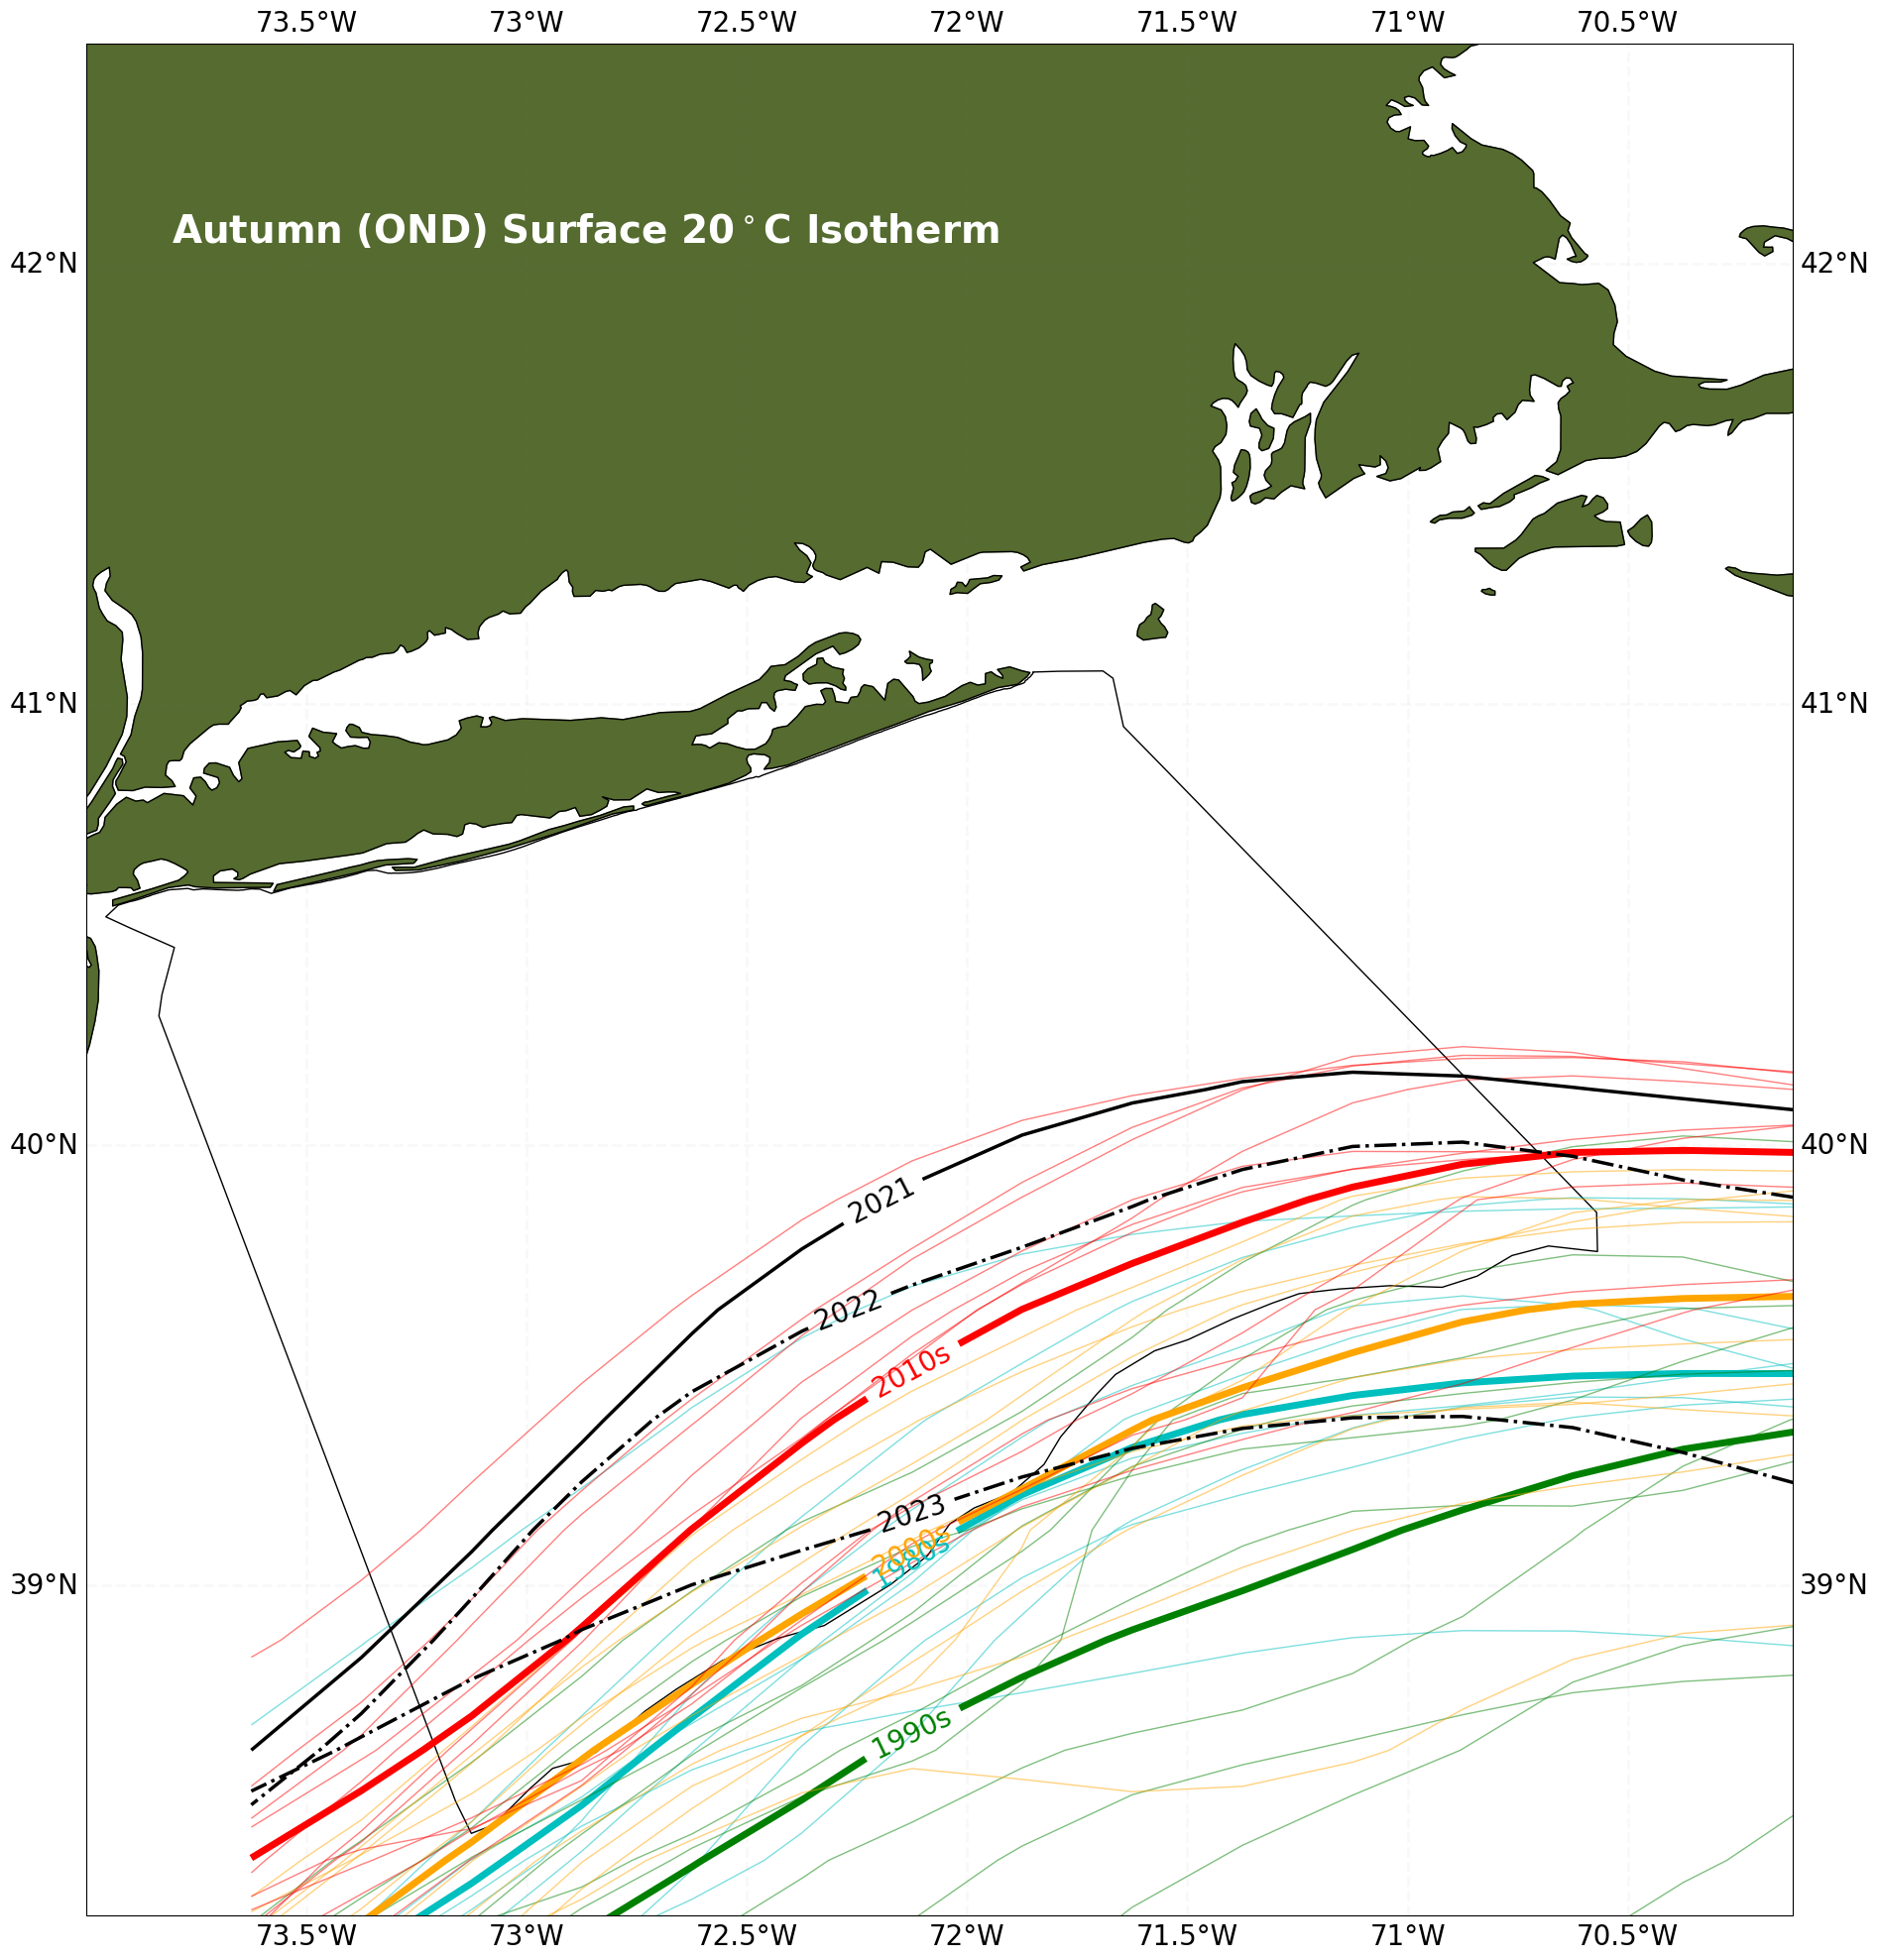

In [79]:
fig,ax = plt.subplots(ncols = 1, nrows = 1, figsize = [20,20],subplot_kw={'projection': ccrs.PlateCarree()})
extent = [286,289.875,38.25,42.5]
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.05, linestyle='--')
ax.coastlines(resolution='10m')
ax.set_extent(extent)
ax.add_feature(cartopy.feature.LAND, color = 'darkolivegreen')
ax.add_geometries(NYB.geometry,
                  ccrs.PlateCarree(),
                  facecolor='none', edgecolor = 'k')
for i in range(len(OND)):
    if np.nanmax(sst_seas[OND[i],:,:]) >= 20:
        text = np.arange(1982,2025,1)
        text2 = str(text[i])
        if text[i]<1990:
            if text[i] == 1982:
                a = i
            if text[i] == 1989:
                b = i
                CS1 = ax.contour(seas.longitude[25:40],seas.latitude, np.nanmean(sst_seas[OND[a:b+1],:,25:40],0),levels=[20], colors = 'c',linewidths = 5)
                ax.clabel(CS1, fontsize = 20, inline =1, fmt='1980s')
            ax.contour(sst.longitude[25:40],sst.latitude,sst_seas[OND[i],:,25:40],levels = [20],colors='c',alpha = 0.5, linewidths = 1,transform=ccrs.PlateCarree())
        if text[i]>=1990 and text[i]<2000:
            if text[i] == 1990:
                a = i
            if text[i] == 1999:
                b = i
                CS2 = ax.contour(seas.longitude[25:40],seas.latitude, np.nanmean(sst_seas[OND[a:b+1],:,25:40],0),levels=[20], colors = 'g',linewidths = 5)
                ax.clabel(CS2, fontsize = 20, inline =1, fmt='1990s')            
            ax.contour(sst.longitude[25:40],sst.latitude,sst_seas[OND[i],:,25:40],levels = [20],colors='g',alpha = 0.5, linewidths = 1,transform=ccrs.PlateCarree())
        if text[i]>=2000 and text[i]<2010:
            if text[i] == 2000:
                a = i
            if text[i] == 2009:
                b = i
                CS3 = ax.contour(seas.longitude[25:40],seas.latitude, np.nanmean(sst_seas[OND[a:b+1],:,25:40],0),levels=[20], colors = 'orange',linewidths = 5)
                ax.clabel(CS3, fontsize = 20, inline =1, fmt='2000s')            
            ax.contour(sst.longitude[25:40],sst.latitude,sst_seas[OND[i],:,25:40],levels = [20],colors='orange',alpha = 0.5, linewidths = 1,transform=ccrs.PlateCarree())
        if text[i]>=2010 and text[i] < 2021:
            if text[i] == 2010:
                a = i
            if text[i] == 2019:
                b = i
                CS4 = ax.contour(seas.longitude[25:40],seas.latitude, np.nanmean(sst_seas[OND[a:b+1],:,25:40],0),levels=[20], colors = 'r',linewidths = 5)
                ax.clabel(CS4, fontsize = 20, inline =1, fmt='2010s')            
            ax.contour(sst.longitude[25:40],sst.latitude,sst_seas[OND[i],:,25:40],levels = [20],colors='r',alpha = 0.5, linewidths = 1,transform=ccrs.PlateCarree())
        if text[i] ==2021:
            CS = ax.contour(sst.longitude[25:40],sst.latitude,sst_seas[OND[i],:,25:40],levels = [20],colors='k',linewidths = 2.5,transform=ccrs.PlateCarree())
            ax.clabel(CS, fontsize=20, inline=1, fmt=text2)
        if text[i] ==2022:
            CS = ax.contour(sst.longitude[25:40],sst.latitude,sst_seas[OND[i],:,25:40],levels = [20],colors='k',linewidths = 2.5,transform=ccrs.PlateCarree(), linestyles = '-.')
            ax.clabel(CS, fontsize=20, inline=1, fmt=text2)
        if text[i] ==2023:
            CS = ax.contour(sst.longitude[25:40],sst.latitude,sst_seas[OND[i],:,25:40],levels = [20],colors='k',linewidths = 2.5,transform=ccrs.PlateCarree(), linestyles = '-.')
            ax.clabel(CS, fontsize=20, inline=1, fmt=text2)
            
ax.text(0.05, 0.9, 'Autumn (OND) Surface 20$^\circ$C Isotherm', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize = 28, color = 'white', weight = 'bold')

gl.xlabels_top = False
gl.xlabels_bottom = True
gl.ylabels_right = False
gl.ylabel_style = {'size': 20, 'color': 'k'}
gl.xlabel_style = {'size': 20, 'color': 'k'}
plt.tight_layout()

## You can stop here.  The autumn and summer 20C isotherm figures for the indicator report are above.  Everything below here is either old, or experiments/trying different ways to represent the data

In [294]:
def inNYB(longitude, latitude, time, sst, shape):
    X = longitude
    Y = latitude
    y, x = np.meshgrid(X,Y)
    empty = np.empty([len(time), len(latitude), len(longitude)])
    empty[:,:,:] = np.nan
    for j in range(len(longitude)):
        for i in range(len(latitude)):
            if Point(y[i,j], x[i,j]).within(shape) == True:
                empty[:,i,j] = sst[:,i,j]
    return empty

In [293]:
X = (sst.longitude-360)
Y = sst.latitude
y, x = np.meshgrid(X,Y)
np.shape(x)
np.shape(Y)
x[10,10]
y[10,10]
Point(y[30,30], x[30,30]).within(nyb_shape)

True

In [292]:
x[30,30]
y[30,30]

72.375

In [150]:
#sst.time
time_SON = np.arange(1982,2022
          ,1)
time_JJA = np.arange(1982,2023
          ,1)

In [295]:
son_NYB = inNYB(sst.longitude-360,sst.latitude,time_SON,sst_seas[SON],nyb_shape)
np.shape(son_NYB)

jja_NYB = inNYB(sst.longitude-360,sst.latitude,time_JJA,sst_seas[JJA],nyb_shape)
np.shape(jja_NYB)

(41, 57, 81)

<ipython-input-307-c3775484057f>:5: UserWarning: No contour levels were found within the data range.
  C = plt.contour(sst.longitude[25:40]-360,sst.latitude,jja_NYB[i,:,25:40],levels = [20])


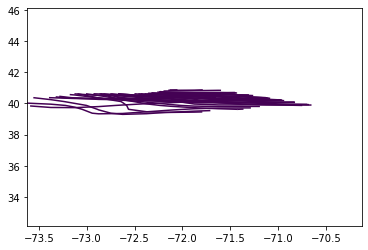

In [307]:
min_lon_JJA = np.empty(41)
lat_lon_JJA = np.empty(41)
for i in range(41):
    line=[]
    C = plt.contour(sst.longitude[25:40]-360,sst.latitude,jja_NYB[i,:,25:40],levels = [20])
    line = C.allsegs[0][0]
    if len(line) == 1:
        min_lon_JJA[i] = np.nan
        lat_lon_JJA[i] = np.nan
    else:
        min_lon_JJA[i] = np.min(line)
        lat_lon_JJA[i] = line[np.where(line[:,0]==np.min(line)),1][0][0]

In [308]:
lat_lon_JJA

array([40.375     , 40.625     , 40.375     , 40.625     , 40.625     ,
       40.625     , 40.42542646, 40.625     , 40.625     , 40.625     ,
       40.02361128, 40.625     , 40.64187871, 40.625     , 40.57229801,
       40.625     , 40.63751012,         nan, 40.46316659, 40.625     ,
       40.64233199, 39.84212491, 40.62133427, 40.76587698, 40.75701213,
       40.625     , 40.80233178, 40.625     ,         nan,         nan,
               nan, 40.67757585, 40.625     , 40.86760453,         nan,
       40.73791731,         nan, 40.85251992,         nan,         nan,
       40.67711273])

<ipython-input-302-7664526faa7c>:5: UserWarning: No contour levels were found within the data range.
  C = plt.contour(sst.longitude[25:40]-360,sst.latitude,jja_NYB[i,:,25:40],levels = [20])


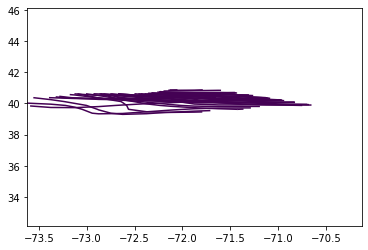

In [302]:
min_lon_JJA = np.empty(41)
lat_lon_JJA = np.empty(41)
for i in range(41):
    line=[]
    C = plt.contour(sst.longitude[25:40]-360,sst.latitude,jja_NYB[i,:,25:40],levels = [20])
    line = C.allsegs[0][0]
    if len(line) == 1:
        min_lon_JJA[i] = np.nan
        lat_lon_JJA[i] = np.nan
    else:
        min_lon_JJA[i] = np.min(line)
        #lat_lon_JJA[i] = line[np.where(line[:,0]==np.min(line)),1][0][0]

<ipython-input-298-fe1aff93af80>:5: UserWarning: No contour levels were found within the data range.
  C = plt.contour(sst.longitude[25:40]-360,sst.latitude,son_NYB[i,:,25:40],levels = [20])


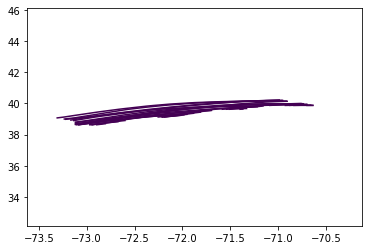

In [298]:
max_lat_SON = np.empty(40)
lat_lon_SON = np.empty(40)
for i in range(40):
    line=[]
    C = plt.contour(sst.longitude[25:40]-360,sst.latitude,son_NYB[i,:,25:40],levels = [20])
    line = C.allsegs[0][0]
    if len(line) == 1:
        max_lat_SON[i] = np.nan
        lat_lon_SON[i] = np.nan
    else:
        max_lat_SON[i] = np.max(line)
        lat_lon_SON[i] = line[np.where(line[:,0]==np.min(line)),0][0][0]

In [236]:
max_lat_SON[0]

40.625

40.442017139910476

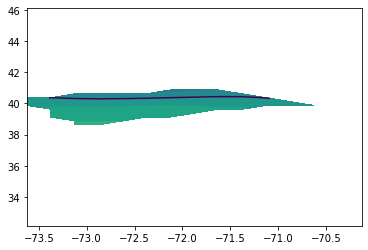

In [303]:
plt.contourf(sst.longitude[25:40]-360, sst.latitude[:], jja_NYB[2,:,25:40],levels = np.arange(11,30,1))
C = plt.contour(sst.longitude[25:40]-360, sst.latitude[:], jja_NYB[2,:,25:40], levels = [20])
line = C.allsegs[0][0]
line
np.max(line)

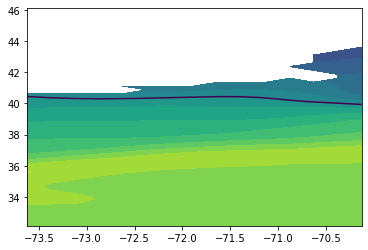

In [304]:
plt.contourf(sst.longitude[25:40]-360, sst.latitude[:], sst_seas[JJA[2],:,25:40], levels = np.arange(11,30,1))
C = plt.contour(sst.longitude[25:40]-360, sst.latitude[:], sst_seas[JJA[2],:,25:40], levels = [20])

line = C.allsegs[0][0]

Text(0.5, 0, 'Longitude')

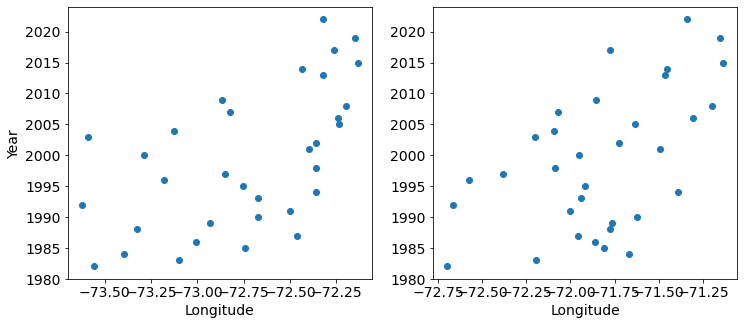

In [305]:
fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = [12,5])
ax[0].scatter(min_lon_JJA,np.arange(1982,2023))
ax[0].tick_params(labelsize = 14)
ax[0].set_ylabel('Year', fontsize = 14)
ax[0].set_xlabel('Longitude', fontsize = 14)

ax[1].scatter(lat_lon_JJA,np.arange(1982,2023))
ax[1].tick_params(labelsize = 14)
#ax[0].set_ylabel('Year', fontsize = 14)
ax[1].set_xlabel('Longitude', fontsize = 14)

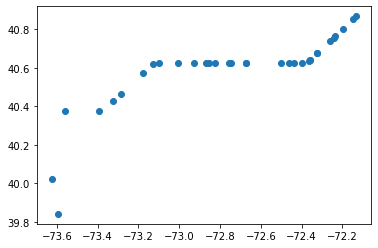

In [309]:
plt.scatter(min_lon_JJA,lat_lon_JJA)

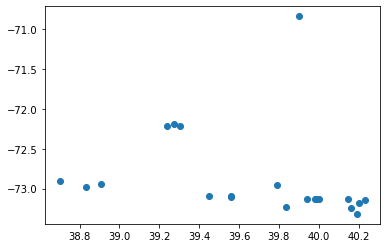

In [300]:
plt.scatter(max_lat_SON, lat_lon_SON)

In [320]:
max_lat_SON = np.append(max_lat_SON,np.nan)
lat_lon_SON = np.append(lat_lon_SON, np.nan)

In [333]:
d = {'SON_lat': max_lat_SON,'SON_lon': lat_lon_SON, 'JJA_lat': lat_lon_JJA, 'JJA_lon' : min_lon_JJA}
Iso20_2022 = pn.DataFrame(data = d, index = time_JJA)
Iso20_2022.to_csv('/Users/nyelab/Desktop/NYB Indicators/NYB_Indicators_Calculations/Final_Timeseries_Figures/Timeseries_Files_2022/Iso20_Aug_26_2022.csv')

In [331]:
len(max_lat_SON)

41

In [330]:
max_lat_SON = np.append(max_lat_SON,np.nan)

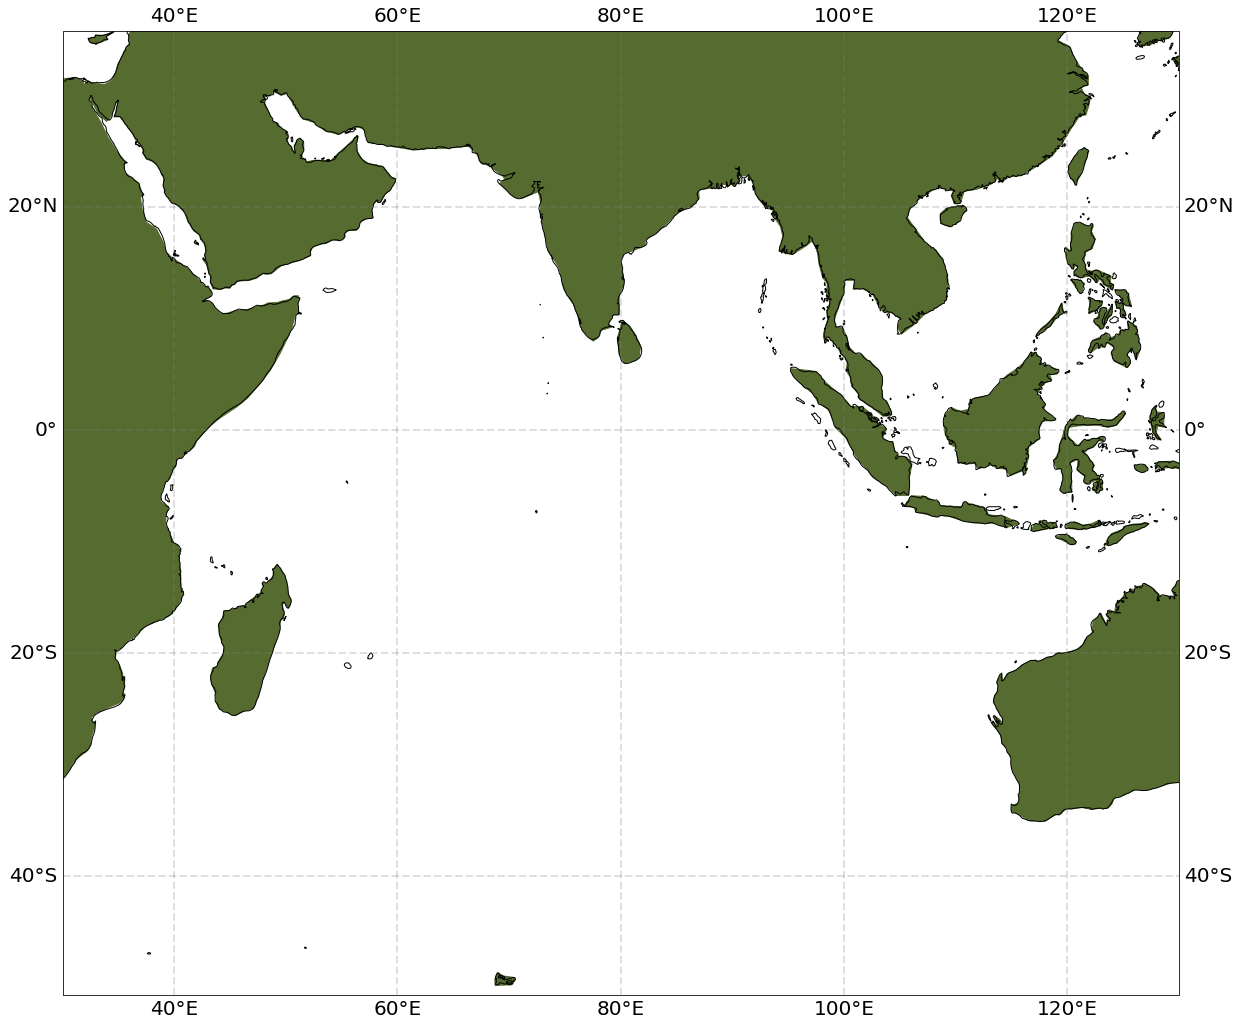

In [19]:
fig,ax = plt.subplots(ncols = 1, nrows = 1, figsize = [20,20],subplot_kw={'projection': ccrs.PlateCarree()})
extent = [30,130,-38.25,25]
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.25, linestyle='--')
ax.coastlines(resolution='50m')
ax.set_extent(extent)
ax.add_feature(cartopy.feature.LAND, color = 'darkolivegreen')
#ax.add_geometries(NYB.geometry,
#                  ccrs.PlateCarree(),
#                  facecolor='none', edgecolor = 'k')
gl.ylabel_style = {'size': 20, 'color': 'k'}
gl.xlabel_style = {'size': 20, 'color': 'k'}

In [44]:
T6 = T6.reset_index()

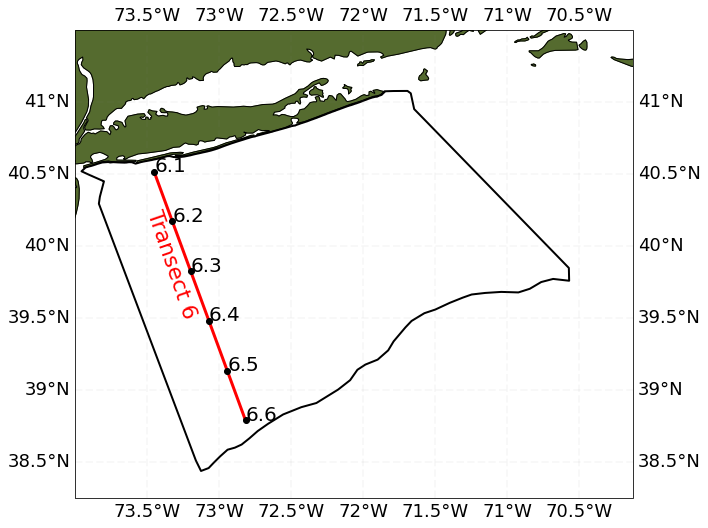

In [72]:
fig,ax = plt.subplots(ncols = 1, nrows = 1, figsize = [10,10],subplot_kw={'projection': ccrs.PlateCarree()})
extent = [286,289.875,38.25,41.5]
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.05, linestyle='--')
ax.coastlines(resolution='10m')
ax.set_extent(extent)
ax.add_feature(cartopy.feature.LAND, color = 'darkolivegreen')
ax.add_geometries(NYB.geometry,
                  ccrs.PlateCarree(),
                  facecolor='none', edgecolor = 'k', linewidth = 2)
ax.plot(T6.LON, T6.LAT, linewidth = 3, c = 'r')
scat = ax.scatter(T6.LON, T6.LAT,c = 'k', zorder = 3)
for i, txt in enumerate(np.array(T6.Waypoint)):
    ax.annotate(txt, (T6.LON[i], T6.LAT[i]), fontsize = 20)
ax.annotate('Transect 6', (-73.53,39.5), c = 'r', fontsize = 22, rotation = -71)
gl.ylabel_style = {'size': 18, 'color': 'k'}
gl.xlabel_style = {'size': 18, 'color': 'k'}

In [4]:
stations = pn.read_csv('/Users/nyelab/Downloads/nyos_station_list.csv')

In [7]:
T6 = stations[stations['Transect'] == 6]

In [8]:
T6

Waypoint       Type        Depth        LON        LAT  Transect
27       6.1        CTD   -19.430363 -73.451237  40.514641         6
28       6.2        CTD   -41.398098 -73.324238  40.169191         6
29       6.3  CTD-PLUME   -45.021019 -73.197239  39.823742         6
30       6.4  CTD-PLUME   -66.923309 -73.070240  39.478292         6
31       6.5        CTD   -81.326416 -72.943241  39.132842         6
32       6.6        CTD -1392.581700 -72.816243  38.787392         6